# Sistem Prediksi Penyakit Kardiovaskular berdasarkan Faktor Risiko Diabetes dan Gaya Hidup melalui pendekatan Hybrid Logika Fuzzy dan Supervised Machine Learning

Dirasiella Damasari Hamdani

# **Inisiasi**

In [3]:
#Importing fuzzy and supervised learning algorithms packages
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.7 MB/s eta 0:00:00


In [4]:
!pip install scikit-learn

In [5]:
#Import Necessary libraries
import numpy as np
import pandas as pd

#Import Logika Fuzzy
import skfuzzy as fuzz
import skfuzzy.control as ctrl #untuk membangun kontrol sistem fuzzy

#Import Model Machine Learning
from sklearn import datasets, model_selection, metrics
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV #untuk melakukan splitting database
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder #untuk melakukan standarisasi fitur yang direkomendasikan untuk algoritma KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix #untuk mengukur validasi
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

#Import library untuk melakukan visualisasi
import matplotlib.pyplot as plt #untuk melakukan visualisasi grafik secara statik, animasi dan interaktif
import matplotlib.patches as patches
import seaborn as sns

#Import library untuk mengatasi database yang imbalance
from imblearn.over_sampling import SMOTE #untuk oversampling pada syntethic kelas minor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline #untuk memastikan teknik sampling dapat diterapkan pada cross-validation atau proses validasi

# **A. Proses Persiapan Data (Data Collection & Data Preprocessing)**

Dikarenakan data primer yang dimiliki dalam jumlah yang kecil, maka dilakukan kombinasi data dengan data eksternal dengan pertimbangan:
1. Data eksternal memiliki variable yang sama, dan menambahkan kolom "country of origin
2. Melakukan data merging dengan menormalisasi struktur data yang dimiliki
3. Melakukan augmentasi data sehingga meningkatkan diversitas data

In [ ]:
#Menyusun dataset dengan mengagregasikan dua dataset yang berbeda

df_id = pd.read_excel('data_xxx.xlsx')
df_us = pd.read_csv('data_us.csv')

print(df_id.head(2))
print(df_us.head(2))

        ID       DATE  AGE   SEX        BMI  TYPE DM  GLUCOSE  HBA1C  SYS  \
0  M202037 2019-01-19   50  Male  24.314124        2      173    NaN  135   
1  M202037 2020-01-24   51  Male  21.564545        2      344    NaN  132   

   DYS  SMOKE  ALCOHOL    LDL  TLDL  HIPERTENSI  STROKE  HATTACK  \
0   70      0        0    NaN   125           0       0        0   
1   74      0        0  104.0   136           0       0        0   

   MEDICAL TREATMENT  
0                NaN  
1                NaN  
  General_Health                  Checkup Exercise Heart_Disease Skin_Cancer  \
0           Poor  Within the past 2 years       No            No          No   
1      Very Good     Within the past year       No           Yes          No   

  Other_Cancer Depression Diabetes Arthritis     Sex Age_Category  \
0           No         No       No       Yes  Female        70-74   
1           No         No      Yes        No  Female        70-74   

   Height_(cm)  Weight_(kg)    BMI Smoking_Hi

In [ ]:
### Melakukan agregasi kedua dataframe dengan langkah awal melakukan augmentasi kolom yang memiliki makna sama
#1. Rename columns on both dataset with same intent
df_id.rename(columns={
    'SEX':'Sex',
    'TYPE DM':'Diabetes',
    'SMOKE':'Smoking_History',
    'ALCOHOL':'Alcohol_Consumption',
    'AGE':'Age'
}, inplace=True)

df_us.rename(columns={
    'Age_Category':'Age'

},inplace=True)
df_id['Age'] = df_id['Age'].astype(str)
df_us['Age'] = df_us['Age'].astype(str)

In [ ]:
# Melakukan konversi value dengan mendefinisikan fungsi yang akan diaplikasikan pada atribut age
age_ranges = df_us['Age'].unique()
age_ranges_dict = {}
for age_range in age_ranges:
    age_range = str(age_range).strip()
    if pd.isna(age_range) or age_range == '':
        print(f"Empty data: '{age_range}'")
        continue
    if '+' in age_range:
        try:
            min_age = int(age_range.rstrip('+'))
            max_age = float('inf')
            age_ranges_dict[(min_age, max_age)] = age_range
        except ValueError:
            print(f"Case '+': '{age_range}'")
    elif '-' in age_range:
        try:
            min_age, max_age = map(int, age_range.split('-'))
            age_ranges_dict[(min_age, max_age)] = age_range
        except ValueError:
            print(f"Case '-': '{age_range}'")
    else:
        print(f"Other : '{age_range}'")
print(age_ranges_dict)

# Fungsi untuk mapping age pada dataset df_id pada age_ranges_dict
def map_age_to_range(age):
    if pd.isna(age):  # Skip NaN ages
        return None
    try:
        age = int(age)  # Ensure age is an integer
    except ValueError:
        print(f"Non-numeric age value encountered: {age}")
        return None
    for (min_age, max_age), age_label in age_ranges_dict.items():
        if min_age <= age <= max_age:
            return age_label
    return None

df_id['Age'] = df_id['Age'].apply(map_age_to_range)
print(df_id['Age'].head(5))

{(70, 74): '70-74', (60, 64): '60-64', (75, 79): '75-79', (80, inf): '80+', (65, 69): '65-69', (50, 54): '50-54', (45, 49): '45-49', (18, 24): '18-24', (30, 34): '30-34', (55, 59): '55-59', (35, 39): '35-39', (40, 44): '40-44', (25, 29): '25-29'}
0    50-54
1    50-54
2    50-54
3    50-54
4    45-49
Name: Age, dtype: object


0     False
1     False
2     False
3     False
4     False
      ...  
93    False
94    False
95    False
96    False
97    False
Name: Age, Length: 98, dtype: bool

In [ ]:
df_id['Age'].isnull()

0     False
1     False
2     False
3     False
4     False
      ...  
93    False
94    False
95    False
96    False
97    False
Name: Age, Length: 98, dtype: bool

In [ ]:
# Melakukan drop data untuk pasien yang tidak mengalami diabetes dari df_us
print(df_us['Diabetes'].value_counts())

value = ["Yes", "Yes, but female told only during pregnancy"]
df_us_diabetes = df_us[df_us['Diabetes'].isin(value)]

print(df_us_diabetes.head(5))

Diabetes
No                                            259141
Yes                                            40171
No, pre-diabetes or borderline diabetes         6896
Yes, but female told only during pregnancy      2646
Name: count, dtype: int64
   General_Health               Checkup Exercise Heart_Disease Skin_Cancer  \
1       Very Good  Within the past year       No           Yes          No   
2       Very Good  Within the past year      Yes            No          No   
3            Poor  Within the past year      Yes           Yes          No   
9            Fair  Within the past year       No            No          No   
11           Fair  Within the past year       No           Yes         Yes   

   Other_Cancer Depression Diabetes Arthritis     Sex    Age  Height_(cm)  \
1            No         No      Yes        No  Female  70-74        165.0   
2            No         No      Yes        No  Female  60-64        163.0   
3            No         No      Yes        No    Male

In [ ]:
"""
1. Melakukan perubahan data pada smoking history df_id
    dengan asumsi 0 (non-smoke) adalah No and 1(passive smoke) dan 2(active smoke) adalah Yes.
2. Selain itu dilakukan juga perubahan pada data acohol consumption df_id
    dengan mengasumsi 0 berarti tidak minum alkohol
    1 berarti pasive dengan mengambil nilai tengah dari range konsumsi alkohol df_us
    2 berarti aktif dengan mengambil nilai maksimal dari range konsumsi alkohol df_us
3. Lalu dilakukan juga perubahan data pada diabetes df_id
    di mana 2 berarti Yes

"""
df_id['Smoking_History'] = df_id['Smoking_History'].map({0:'No', 1:'Yes', '2' : 'Yes'})
df_id['Alcohol_Consumption'] = df_id['Alcohol_Consumption'].map({0: 0.0, 1: 15.0, 2:30.0})
df_id['Diabetes'] = df_id['Diabetes'].replace(2,'Yes')
print(df_id.head(5))

        ID       DATE    Age   Sex        BMI Diabetes  GLUCOSE  HBA1C  SYS  \
0  M202037 2019-01-19  50-54  Male  24.314124      Yes      173    NaN  135   
1  M202037 2020-01-24  50-54  Male  21.564545      Yes      344    NaN  132   
2  M202144 2019-03-09  50-54  Male  25.765713      Yes      141    NaN  136   
3  M202144 2020-02-04  50-54  Male  27.580200      Yes      197    NaN  136   
4  M202539 2019-03-12  45-49  Male  27.852008      Yes      193    NaN  114   

   DYS Smoking_History  Alcohol_Consumption    LDL  TLDL  HIPERTENSI  STROKE  \
0   70              No                  0.0    NaN   125           0       0   
1   74              No                  0.0  104.0   136           0       0   
2   74              No                  0.0    NaN   144           0       0   
3   80              No                  0.0   58.0   129           0       0   
4   64             NaN                  0.0    NaN   170           0       0   

   HATTACK  MEDICAL TREATMENT  
0        0  

In [ ]:
#Melakukan Augmentasi atau Merged Dataframe dari kedua dataframe tersebut

data_final = pd.merge(df_id, df_us_diabetes, how ='outer')
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42915 entries, 0 to 42914
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           42914 non-null  object 
 1   Sex                           42915 non-null  object 
 2   BMI                           42915 non-null  float64
 3   Diabetes                      42915 non-null  object 
 4   GLUCOSE                       98 non-null     float64
 5   HBA1C                         7 non-null      float64
 6   SYS                           98 non-null     float64
 7   DYS                           98 non-null     float64
 8   Smoking_History               42886 non-null  object 
 9   Alcohol_Consumption           42915 non-null  float64
 10  LDL                           62 non-null     float64
 11  TLDL                          98 non-null     float64
 12  HIPERTENSI                    98 non-null     float64
 13  S

In [ ]:
data_final.rename(columns={
    'GLUCOSE':'Glucose',
    'Diabetes':'Diabetes_diagnose',
    'HBA1C':'HBA1C_Result',
    'SYS':'Systolic_pressure',
    'DYS' : 'Diastolic_pressure',
    'LDL' : 'LDL_cholesterol',
    'TLDL' : 'VLDL_cholesterol',
    'HIPERTENSI' :'Hypertension_det',
    'STROKE' : 'Stroke_det',
    'HATTACK':'Heart_attack_det',
    'MEDICAL TREATMENT' : 'med_treatment',
    'Checkup' : 'Latest_checkup',
}, inplace=True)

data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42915 entries, 0 to 42914
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           42914 non-null  object 
 1   Sex                           42915 non-null  object 
 2   BMI                           42915 non-null  float64
 3   Diabetes_diagnose             42915 non-null  object 
 4   Glucose                       98 non-null     float64
 5   HBA1C_Result                  7 non-null      float64
 6   Systolic_pressure             98 non-null     float64
 7   Diastolic_pressure            98 non-null     float64
 8   Smoking_History               42886 non-null  object 
 9   Alcohol_Consumption           42915 non-null  float64
 10  LDL_cholesterol               62 non-null     float64
 11  VLDL_cholesterol              98 non-null     float64
 12  Hypertension_det              98 non-null     float64
 13  S

# **B. Data Pre-Processing**

## **B.1 Data Handling (Missing Value)**

In [ ]:
#Mengatasi null-value
null = data_final.isnull().sum()
print (null[null>0])

Glucose                         42152
HBA1C_Result                    42242
Systolic_pressure               42152
Diastolic_pressure              42152
Smoking_History                    28
LDL_cholesterol                 42187
VLDL_cholesterol                42152
Hypertension_det                42152
Stroke_det                      42152
Heart_attack_det                42152
med_treatment                   42249
General_Health                     97
Exercise                           97
Skin_Cancer                        97
Other_Cancer                       97
Depression                         97
Arthritis                          97
Height_(cm)                        97
Weight_(kg)                        97
Fruit_Consumption                  97
Green_Vegetables_Consumption       97
FriedPotato_Consumption            97
dtype: int64


Setelah melihat kolom yang memiliki null values tersebut, penelitian ini akan melakukan drop columns dengan konsiderasi kolom yang tidak memiliki relevansi terhadap kebutuhan bisnis yang telah didefinisikan sebelumnya, yakni pada kolom other_cancer,arthritis, skin_cancer dan med_treatment.

Selain itu, dilakukan juga drop columns untuk height dan weight, dikarenakan sudah terepresentasikan melalui kolom BMI.

In [ ]:
#Melakukan drop columns
columns_to_drop_2 = ['Skin_Cancer', 'Other_Cancer', 'Arthritis','Height_(cm)','Weight_(kg)','med_treatment','Hypertension_det','Stroke_det','Heart_attack_det']
data_final_cleanse = data_final.copy()
data_final_cleanse = data_final_cleanse.drop(columns = columns_to_drop_2)
null2 = data_final_cleanse.isnull().sum()
print (null2[null2>0])

Glucose                         42152
HBA1C_Result                    42242
Systolic_pressure               42152
Diastolic_pressure              42152
Smoking_History                    28
LDL_cholesterol                 42187
VLDL_cholesterol                42152
General_Health                     97
Exercise                           97
Depression                         97
Fruit_Consumption                  97
Green_Vegetables_Consumption       97
FriedPotato_Consumption            97
dtype: int64


In [ ]:
# Melihat statistika untuk null values <100
medium_null_columns = ['Fruit_Consumption','Green_Vegetables_Consumption','FriedPotato_Consumption']
data_final_cleanse[medium_null_columns].describe()

Fruit_Consumption  Green_Vegetables_Consumption  \
count       42152.000000                  42152.000000   
mean           28.690904                     14.028468   
std            24.493862                     14.635435   
min             0.000000                      0.000000   
25%            10.000000                      4.000000   
50%            30.000000                     10.000000   
75%            30.000000                     20.000000   
max           120.000000                    120.000000   

       FriedPotato_Consumption  
count             42152.000000  
mean                  6.244757  
std                   8.669485  
min                   0.000000  
25%                   1.000000  
50%                   4.000000  
75%                   8.000000  
max                 120.000000

In [ ]:
#Melakukan imputasi data dengan memasukan data rata-rata untuk column dengan null <100
for column in medium_null_columns:
  median_value = data_final_cleanse[column].median()
  data_final_cleanse[column].fillna(median_value,inplace=True)

<ipython-input-111-542f8d00c578>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_final_cleanse[column].fillna(median_value,inplace=True)


In [ ]:
null2 = data_final_cleanse.isnull().sum()
print (null2[null2>0])

Glucose               42152
HBA1C_Result          42242
Systolic_pressure     42152
Diastolic_pressure    42152
Smoking_History          28
LDL_cholesterol       42187
VLDL_cholesterol      42152
General_Health           97
Exercise                 97
Depression               97
dtype: int64


In [ ]:
# Melihat statistika untuk null values >100
high_null_columns = ['Glucose','HBA1C_Result', 'Systolic_pressure','Diastolic_pressure','LDL_cholesterol','VLDL_cholesterol']
data_final_cleanse[high_null_columns].describe()

Glucose  HBA1C_Result  Systolic_pressure  Diastolic_pressure  \
count   97.000000      7.000000          97.000000           97.000000   
mean   189.659794      7.252857         132.742268           77.072165   
std     57.264352      1.312170          17.145990           11.072909   
min    126.000000      5.500000         100.000000           57.000000   
25%    144.000000      6.235000         119.000000           68.000000   
50%    172.000000      7.630000         131.000000           75.000000   
75%    226.000000      8.135000         141.000000           86.000000   
max    374.000000      8.900000         187.000000          114.000000   

       LDL_cholesterol  VLDL_cholesterol  
count        62.000000         97.000000  
mean        135.598387        192.886598  
std          44.342299         42.898105  
min          21.000000        104.000000  
25%         105.750000        164.000000  
50%         137.000000        196.000000  
75%         166.750000        223.000000  
max         236.000000        309.000000

In [ ]:
#Melakukan imputasi dengan menggunakan KNN dengan menggunakan standard scaller terlebih dahulu pada kasus null values > 100
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

#1. Melakukan data scaling untuk mengkalkulasi jarak pada tiap poin data yang memberikan output kustomisasi n_neighbors
scaler = StandardScaler()
scaled_columns = scaler.fit_transform(data_final_cleanse[high_null_columns])

#2. Melakukan imputasi KNN
imputer = KNNImputer(n_neighbors=5)
imputed_columns = imputer.fit_transform(scaled_columns)

#3. Inversi data kepada skala original
data_final_cleanse[high_null_columns] = scaler.inverse_transform(imputed_columns)

print(data_final_cleanse[high_null_columns].isnull().sum())

Glucose               0
HBA1C_Result          0
Systolic_pressure     0
Diastolic_pressure    0
LDL_cholesterol       0
VLDL_cholesterol      0
dtype: int64


In [ ]:
null2 = data_final_cleanse.isnull().sum()
print (null2[null2>0])

Smoking_History    28
General_Health     97
Exercise           97
Depression         97
dtype: int64


handling missing value pada data yang berupa object akan terbagi menjadi dua, yakni pada kolom Smoking_History, Exercise, Depression akan diisi dengan Mode(Most Frequent Value)

In [ ]:
cat_columns = ['Smoking_History','Depression','Exercise','General_Health']
for column in cat_columns:
  mode_value = data_final_cleanse[column].mode()[0]
  data_final_cleanse[column].fillna(mode_value,inplace=True)

<ipython-input-116-5ea294c2f4a2>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_final_cleanse[column].fillna(mode_value,inplace=True)


In [ ]:
null2 = data_final_cleanse.isnull().sum()
print (null2[null2>0])

Series([], dtype: int64)


In [ ]:
data_final2 = data_final_cleanse.copy()
data_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42249 entries, 0 to 42248
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           42249 non-null  object 
 1   Sex                           42249 non-null  object 
 2   BMI                           42249 non-null  float64
 3   Diabetes_diagnose             42249 non-null  object 
 4   Glucose                       42249 non-null  float64
 5   HBA1C_Result                  42249 non-null  float64
 6   Systolic_pressure             42249 non-null  float64
 7   Diastolic_pressure            42249 non-null  float64
 8   Smoking_History               42249 non-null  object 
 9   Alcohol_Consumption           42249 non-null  float64
 10  LDL_cholesterol               42249 non-null  float64
 11  VLDL_cholesterol              42249 non-null  float64
 12  Latest_checkup                42249 non-null  object 
 13  H

In [ ]:
data_final2.to_csv('data_cleansed.csv', index = False)

## **B.2 Model Logika Fuzzy**

### **B.2.1. Definisi Fuzzy Membership atau Himpunan Fuzzy**

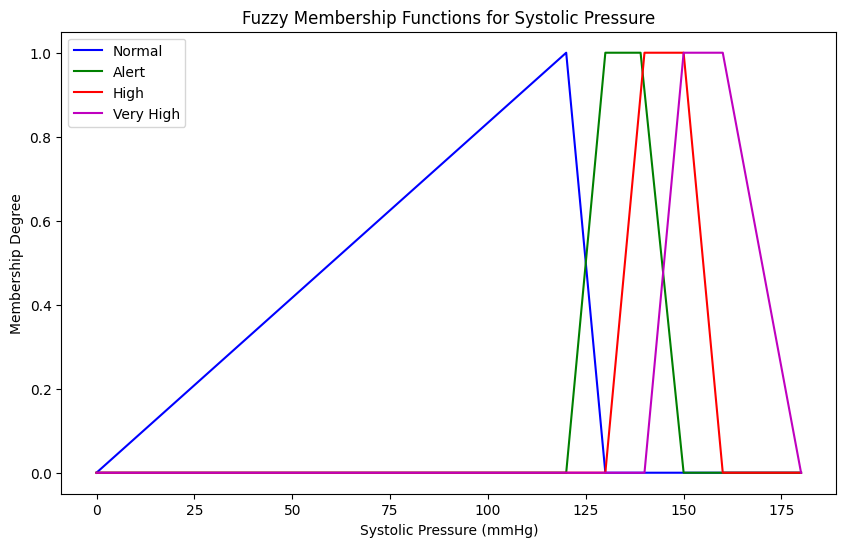

In [6]:
# Melakukan definisi membership fuzzy pada fitur tekanan darah sistolik
systolic_universe = np.arange(0, 181, 1) # definisi semesta himpunan fuzzy pada tekanan darah sistolik dengan rentang 0 sampai 180
sp_normal = fuzz.trimf(systolic_universe, [0, 120, 130]) # Membership tekanan darah normal dengan tipe triangular
sp_alert = fuzz.trapmf(systolic_universe, [120, 130, 139, 150])   # Membership tekanan darah waspada dengan tipe trapezoidal
sp_high = fuzz.trapmf(systolic_universe, [130, 140, 150, 160])  # Membership tekanan darah tinggi dengan tipe trapezoidal
sp_very_high = fuzz.trapmf(systolic_universe, [140, 150, 160, 180])   # Memberhsip tekanan darah sangat tinggi dengan tipe trapezoidal

def systolic_membership(systolic_pressure):
  systolic_pressure['Normal'] = fuzz.trimf(systolic_universe, [0, 120, 130])  # Membership tekanan darah normal dengan tipe triangular
  systolic_pressure['Alert'] = fuzz.trapmf(systolic_universe, [120, 130, 139, 150])  # Membership tekanan darah waspada dengan tipe trapezoidal
  systolic_pressure['High'] = fuzz.trapmf(systolic_universe, [130, 140, 150, 160])  # Membership tekanan darah tinggi dengan tipe trapezoidal
  systolic_pressure['Very High'] = fuzz.trapmf(systolic_universe, [140, 150, 160, 180])  # Memberhsip tekanan darah sangat tinggi dengan tipe trapezoidal

# Visualisasi membership fuzzy
plt.figure(figsize=(10, 6))
plt.plot(systolic_universe, sp_normal,'b',linewidth=1.5, label='Normal')
plt.plot(systolic_universe, sp_alert,'g',linewidth=1.5,  label='Alert')
plt.plot(systolic_universe, sp_high,'r',linewidth=1.5,  label='High')
plt.plot(systolic_universe, sp_very_high,'m',linewidth=1.5,  label='Very High')
plt.title('Fuzzy Membership Functions for Systolic Pressure')
plt.xlabel('Systolic Pressure (mmHg)')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()

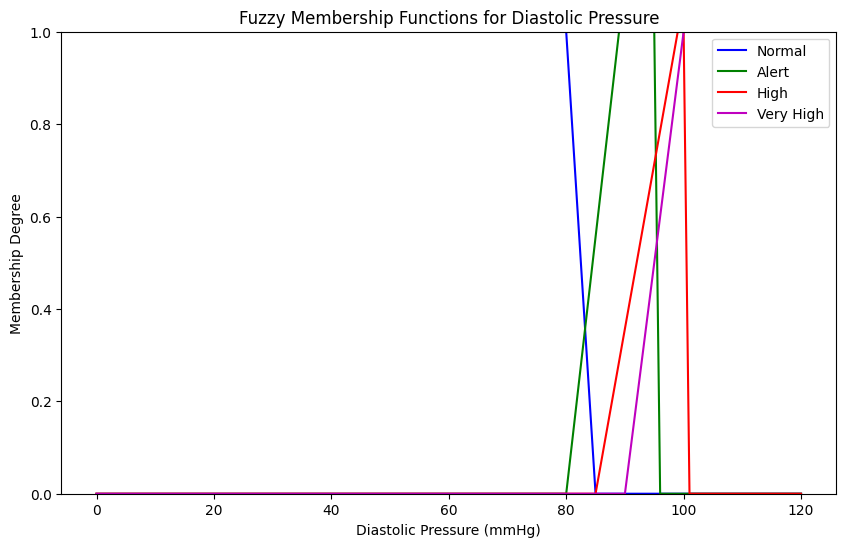

In [7]:
# Melakukan definisi membership fuzzy pada fitur tekanan darah diastolik

diastolic_universe = np.arange(0, 121, 1) # definisi semesta himpunan fuzzy pada tekanan darah diastolic, yakni 0 sampai 120
dp_normal = fuzz.trapmf(diastolic_universe, [0, 0, 80, 85]) # Membership tekanan darah normal dengan tipe triangular
dp_alert = fuzz.trapmf(diastolic_universe, [80, 89, 95, 95])  # Membership tekanan darah waspada dengan tipe trapezoidal
dp_high = fuzz.trapmf(diastolic_universe, [85, 99, 100, 100]) # Membership tekanan darah tinggi dengan tipe trapezoidal
dp_very_high = fuzz.trapmf(diastolic_universe, [90, 100, 120, 120])  # Memberhsip tekanan darah sangat tinggi dengan tipe trapezoidal

def diastolic_membership(diastolic_pressure):
  diastolic_pressure['Normal'] = fuzz.trapmf(diastolic_universe, [0, 0, 80, 85]) # Membership tekanan darah normal dengan tipe triangular
  diastolic_pressure['Alert'] = fuzz.trapmf(diastolic_universe, [80, 89, 95, 95])  # Membership tekanan darah waspada dengan tipe trapezoidal
  diastolic_pressure['High'] = fuzz.trapmf(diastolic_universe, [85, 99, 100, 100]) # Membership tekanan darah tinggi dengan tipe trapezoidal
  diastolic_pressure['Very High'] = fuzz.trapmf(diastolic_universe, [90, 100, 120, 120])  # Memberhsip tekanan darah sangat tinggi dengan tipe trapezoidal

plt.figure(figsize=(10, 6))
plt.plot(diastolic_universe, dp_normal, 'b', linewidth=1.5, label='Normal')
plt.plot(diastolic_universe, dp_alert, 'g', linewidth=1.5, label='Alert')
plt.plot(diastolic_universe, dp_high, 'r', linewidth=1.5, label='High')
plt.plot(diastolic_universe, dp_very_high, 'm', linewidth=1.5, label='Very High')
plt.title('Fuzzy Membership Functions for Diastolic Pressure')
plt.xlabel('Diastolic Pressure (mmHg)')
plt.ylabel('Membership Degree')
plt.ylim([0, 1])  # Set y-axis limits to 0 to 1
plt.legend(loc='best')
plt.show()

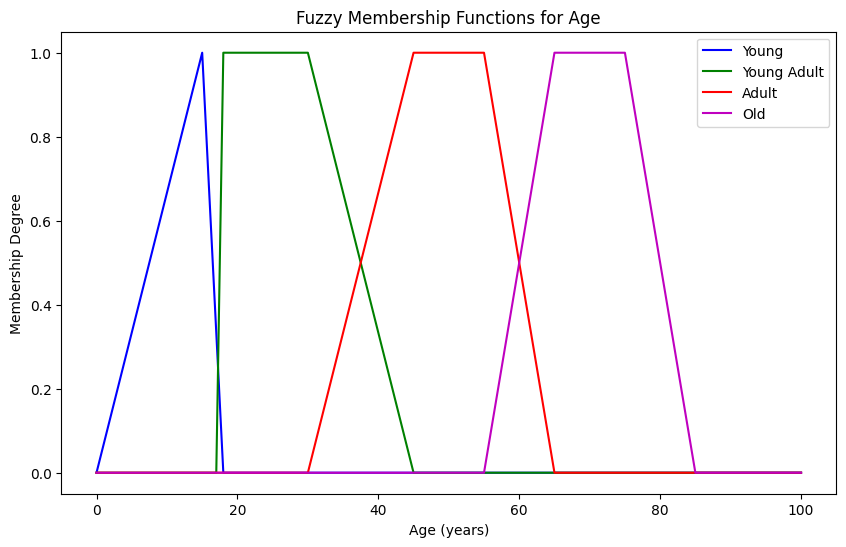

In [8]:
# Melakukan pendefinisian terhadap membership fuzzy age
age_universe = np.arange(0, 101, 1) # Melakukan inisiasi semesta umur
young = fuzz.trimf(age_universe, [0, 15, 18])  # Membership young dengan tipe triangular
young_adult = fuzz.trapmf(age_universe, [18, 18, 30, 45])  # Membership young adult dengan tipe trapezoidal
adult = fuzz.trapmf(age_universe, [30, 45, 55, 65])  # Membership adult dengan tipe trapezoidal
old = fuzz.trapmf(age_universe, [55, 65, 75, 85])  # Membership old dengan tipe trapezoidal

def age_membership(age):
  age['Young'] = fuzz.trimf(age_universe, [0, 15, 18])  # Membership young dengan tipe triangular
  age['Young Adult'] = fuzz.trapmf(age_universe, [18, 30, 35, 45])  # Membership young adult dengan tipe trapezoidal
  age['Adult'] = fuzz.trapmf(age_universe, [30, 45, 55, 65])  # Membership adult dengan tipe trapezoidal
  age['Old'] = fuzz.trapmf(age_universe, [55, 65, 75, 85])  # Membership old dengan tipe trapezoidal

# Visualisasi membership Age
plt.figure(figsize=(10, 6))

plt.plot(age_universe, young, 'b', linewidth=1.5, label='Young')
plt.plot(age_universe, young_adult, 'g', linewidth=1.5, label='Young Adult')
plt.plot(age_universe, adult, 'r', linewidth=1.5, label='Adult')
plt.plot(age_universe, old, 'm', linewidth=1.5, label='Old')

plt.title('Fuzzy Membership Functions for Age')
plt.xlabel('Age (years)')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()


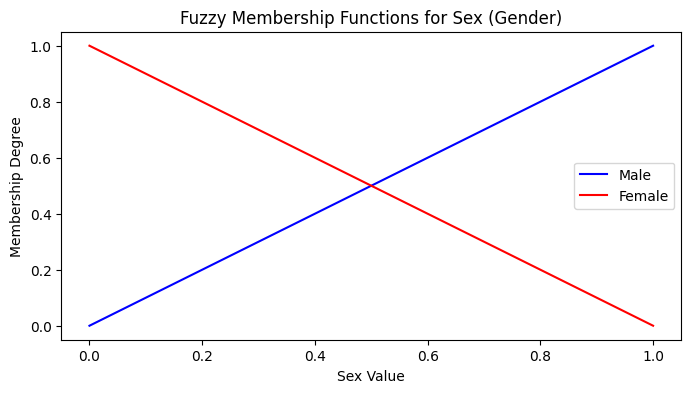

In [9]:
# Melakukan pendefinisian terhadap membership fuzzy sex/gender
sex_universe = np.arange(0, 2, 1) #inisiasi semesta gender
male = fuzz.trimf(sex_universe, [0, 1, 1])  # Membership male dengan triangular, linear
female = fuzz.trimf(sex_universe, [0, 0, 1])# Membership female dengan triangular, linear

def sex_membership(sex):
  sex['Male'] = fuzz.trimf(sex_universe, [0, 1, 1])  # Membership male dengan triangular, linear
  sex['Female'] = fuzz.trimf(sex_universe, [0, 0, 1])# Membership female dengan triangular, linear

# Visualisasi memberhip sex
plt.figure(figsize=(8, 4))
plt.plot(sex_universe, male, 'b', linewidth=1.5, label='Male')
plt.plot(sex_universe, female, 'r', linewidth=1.5, label='Female')

plt.title('Fuzzy Membership Functions for Sex (Gender)')
plt.xlabel('Sex Value')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()

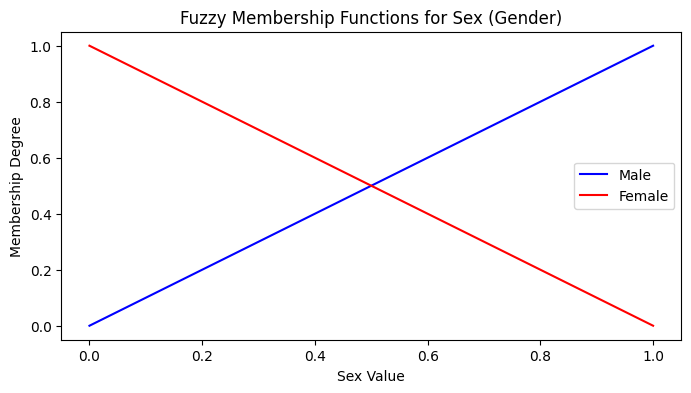

In [10]:
# Melakukan pendefinisian terhadap membership fuzzy sex/gender
sex_universe = np.arange(0, 1.1, 0.1) #inisiasi semesta gender
male = fuzz.trimf(sex_universe, [0, 1, 1])  # Membership male dengan triangular, linear
female = fuzz.trimf(sex_universe, [0, 0, 1])# Membership female dengan triangular, linear

plt.figure(figsize=(8, 4))

plt.plot(sex_universe, male, 'b', linewidth=1.5, label='Male')
plt.plot(sex_universe, female, 'r', linewidth=1.5, label='Female')

plt.title('Fuzzy Membership Functions for Sex (Gender)')
plt.xlabel('Sex Value')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()

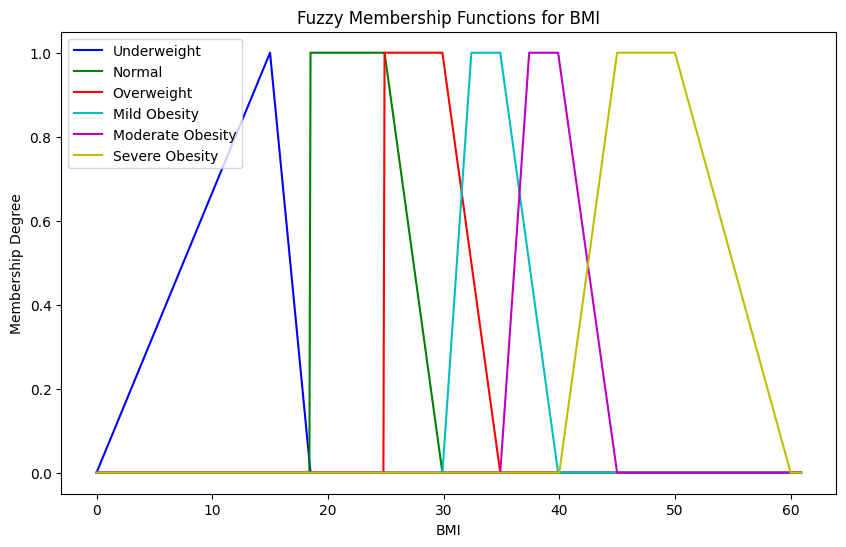

In [11]:
# Melakukan pendefinisian terhadap membership fuzzy BMI
bmi_universe = np.arange(0, 61, 0.1) #inisiasi semesta BMI
underweight = fuzz.trimf(bmi_universe, [0, 15, 18.5])  # Membership underweight dengan tipe Triangular
normal = fuzz.trapmf(bmi_universe, [18.5, 18.5, 24.9, 29.9])  # Membership normal dengan tipe trapezoidal
overweight = fuzz.trapmf(bmi_universe, [24.9, 24.9, 29.9, 34.9])  # Membership overweight dengan tipe trapezoidal
mild_obesity = fuzz.trapmf(bmi_universe, [29.9, 32.4, 34.9, 39.9])  # Membership mild_obesity dengan tipe trapezoidal
moderate_obesity = fuzz.trapmf(bmi_universe, [34.9, 37.4, 39.9, 45])  # Memberhip moderate_obesity dengan tipe Trapezoidal
severe_obesity = fuzz.trapmf(bmi_universe, [40, 45, 50, 60])  # Membership severe_obesity dengan tipe trapezoidal

def bmi_membership(BMI):
  BMI['Underweight'] = fuzz.trimf(bmi_universe, [0, 15, 18.5])  # Membership underweight dengan tipe Triangular
  BMI['Normal'] = fuzz.trapmf(bmi_universe, [18.5, 18.5, 24.9, 29.9])  # Membership normal dengan tipe trapezoidal
  BMI['Overweight'] = fuzz.trapmf(bmi_universe, [24.9, 24.9, 29.9, 34.9])  # Membership overweight dengan tipe trapezoidal
  BMI['Mild Obesity'] = fuzz.trapmf(bmi_universe, [29.9, 32.4, 34.9, 39.9])  # Membership mild_obesity dengan tipe trapezoidal
  BMI['Moderate Obesity'] = fuzz.trapmf(bmi_universe, [34.9, 37.4, 39.9, 45])  # Memberhip moderate_obesity dengan tipe Trapezoidal
  BMI['Severe Obesity'] = fuzz.trapmf(bmi_universe, [40, 45, 50, 60])  # Membership severe_obesity dengan tipe trapezoidal

# Visualisasi membership fuzzy BMI
plt.figure(figsize=(10, 6))
plt.plot(bmi_universe, underweight, 'b', linewidth=1.5, label='Underweight')
plt.plot(bmi_universe, normal, 'g', linewidth=1.5, label='Normal')
plt.plot(bmi_universe, overweight, 'r', linewidth=1.5, label='Overweight')
plt.plot(bmi_universe, mild_obesity, 'c', linewidth=1.5, label='Mild Obesity')
plt.plot(bmi_universe, moderate_obesity, 'm', linewidth=1.5, label='Moderate Obesity')
plt.plot(bmi_universe, severe_obesity, 'y', linewidth=1.5, label='Severe Obesity')

plt.title('Fuzzy Membership Functions for BMI')
plt.xlabel('BMI')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()

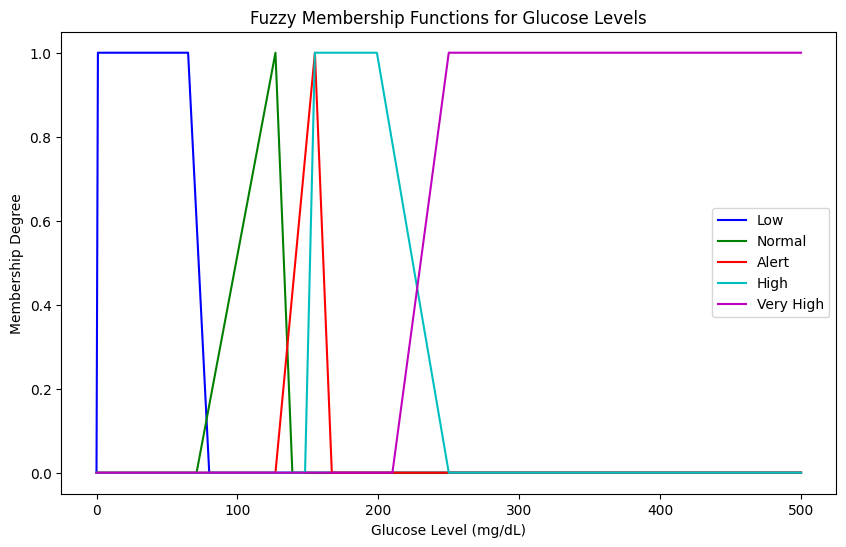

In [12]:
# Melakukan pendefinisian terhadap membership glukosa
glucose_universe = np.arange(0, 501, 1) #inisiasi semesta glukosa
low_glucose = fuzz.trapmf(glucose_universe, [1, 1, 65, 80])  # Membership glukosa rendah dengan tipe trapezoidal
normal_glucose = fuzz.trimf(glucose_universe, [71, 127, 139])  # Membership glukosa normal dengan tipe triangular
alert_glucose = fuzz.trimf(glucose_universe, [127, 155, 167])  # Membership gluksoa waspada dengan tipe triangular
high_glucose = fuzz.trapmf(glucose_universe, [148, 155, 199, 250])  # Membership glukosa tinggi dengan tipe trapezoidal
very_high_glucose = fuzz.trapmf(glucose_universe, [210, 250, 500, 500])  # Membership glukosa sangat tinggi dengan tipe trapezoidal

def glucose_membership(glucose):
  glucose['Low'] = fuzz.trapmf(glucose_universe, [1, 1, 65, 80])  # Membership glukosa rendah dengan tipe trapezoidal
  glucose['Normal'] = fuzz.trimf(glucose_universe, [71, 127, 139])  # Membership glukosa normal dengan tipe triangular
  glucose['Alert'] = fuzz.trimf(glucose_universe, [127, 155, 167])  # Membership gluksoa waspada dengan tipe triangular
  glucose['High'] = fuzz.trapmf(glucose_universe, [148, 155, 199, 250])  # Membership glukosa tinggi dengan tipe trapezoidal
  glucose['Very High'] = fuzz.trapmf(glucose_universe, [210, 250, 500, 500])  # Membership glukosa sangat tinggi dengan tipe trapezoidal

# Visualisasi membership fuzzy
plt.figure(figsize=(10, 6))
plt.plot(glucose_universe, low_glucose, 'b', linewidth=1.5, label='Low')
plt.plot(glucose_universe, normal_glucose, 'g', linewidth=1.5, label='Normal')
plt.plot(glucose_universe, alert_glucose, 'r', linewidth=1.5, label='Alert')
plt.plot(glucose_universe, high_glucose, 'c', linewidth=1.5, label='High')
plt.plot(glucose_universe, very_high_glucose, 'm', linewidth=1.5, label='Very High')

plt.title('Fuzzy Membership Functions for Glucose Levels')
plt.xlabel('Glucose Level (mg/dL)')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()

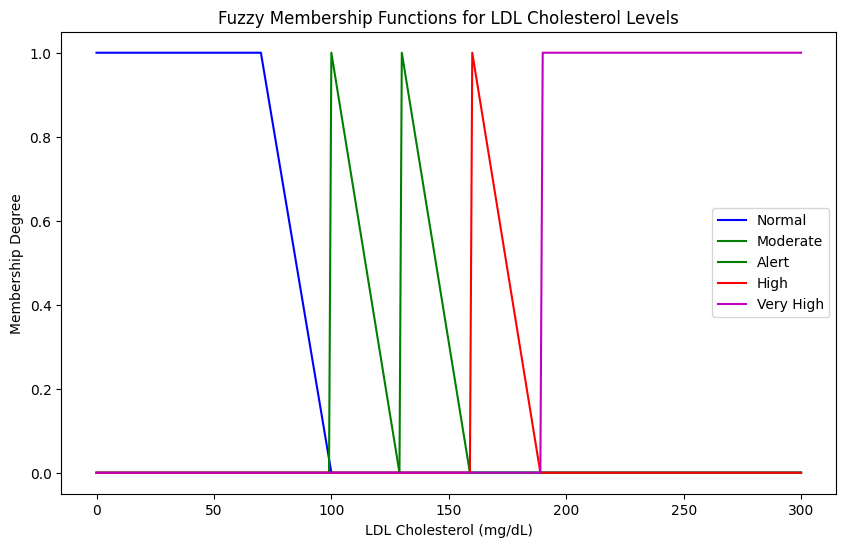

In [13]:
# Melakukan pendefinisian terhadap membership kolesterol ldl
ldl_universe = np.arange(0, 301, 1) #inisiasi semesta kolesterol ldl
ldl_normal = fuzz.trapmf(ldl_universe, [0, 0, 70, 100])  # Memberhsip normal dengan tipe trapezoidal
ldl_moderate = fuzz.trapmf(ldl_universe, [100, 100, 100, 129])  # Membership moderate dengan tipe triangular
ldl_alert = fuzz.trapmf(ldl_universe, [130, 130, 130, 159])  # Membership alert dengan tipe trapezoidal
ldl_high = fuzz.trapmf(ldl_universe, [160, 160, 160, 189])  # Membership high dengan tipe trapezoidal
ldl_very_high = fuzz.trapmf(ldl_universe, [190, 190, 300, 300]) # Memberhip very_high dengan tipe trapezoidal


def cholesterol_membership(ldl_cholesterol):
  ldl_cholesterol['Normal'] = ldl_normal = fuzz.trapmf(ldl_universe, [0, 0, 70, 100])  # Memberhsip normal dengan tipe trapezoidal
  ldl_cholesterol['Moderate'] = ldl_moderate = fuzz.trapmf(ldl_universe, [100, 100, 100, 129])  # Membership moderate dengan tipe triangular
  ldl_cholesterol['Alert'] = fuzz.trapmf(ldl_universe, [130, 130, 130, 159])  # Membership alert dengan tipe trapezoidal
  ldl_cholesterol['High'] = fuzz.trapmf(ldl_universe, [160, 160, 160, 189])  # Membership high dengan tipe trapezoidal
  ldl_cholesterol['Very High'] = fuzz.trapmf(ldl_universe, [190, 190, 300, 300]) # Memberhip very_high dengan tipe trapezoidal

# Visualisasi membership cholesterol
plt.figure(figsize=(10, 6))
plt.plot(ldl_universe, ldl_normal, 'b', linewidth=1.5, label='Normal')
plt.plot(ldl_universe, ldl_moderate, 'g', linewidth=1.5, label='Moderate')
plt.plot(ldl_universe, ldl_alert, 'g', linewidth=1.5, label='Alert')
plt.plot(ldl_universe, ldl_high, 'r', linewidth=1.5, label='High')
plt.plot(ldl_universe, ldl_very_high, 'm', linewidth=1.5, label='Very High')

plt.title('Fuzzy Membership Functions for LDL Cholesterol Levels')
plt.xlabel('LDL Cholesterol (mg/dL)')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()


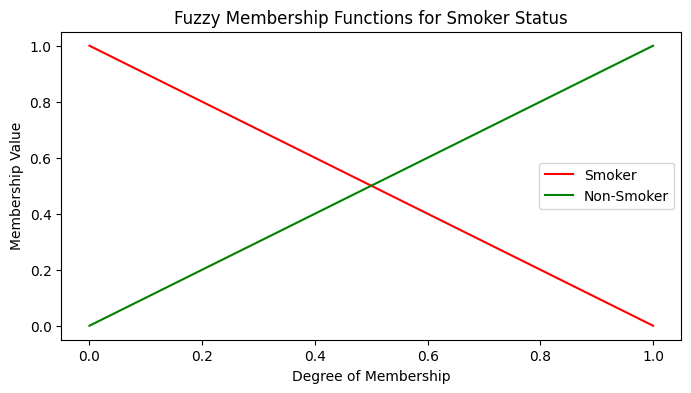

In [14]:
# Melakukan pendefinisian terhadap membership smoke
smoker_universe = np.arange(0, 2, 1)

smoker = fuzz.trimf(smoker_universe, [0, 0, 1])  # Membership smoker dengan tipe triangular
non_smoker = fuzz.trimf(smoker_universe, [0, 1, 1])  # Membership non smoker dengan tipe triangular
def smoke_membership(smoking_history):
  smoking_history['Smoker'] = fuzz.trimf(smoker_universe, [0, 0, 1])
  smoking_history['Non-Smoker'] = fuzz.trimf(smoker_universe, [0, 1, 1])

# Visualisasi membership
plt.figure(figsize=(8, 4))

plt.plot(smoker_universe, smoker, 'r', linewidth=1.5, label='Smoker')
plt.plot(smoker_universe, non_smoker, 'g', linewidth=1.5, label='Non-Smoker')

plt.title('Fuzzy Membership Functions for Smoker Status')
plt.xlabel('Degree of Membership')
plt.ylabel('Membership Value')
plt.legend(loc='best')
plt.show()


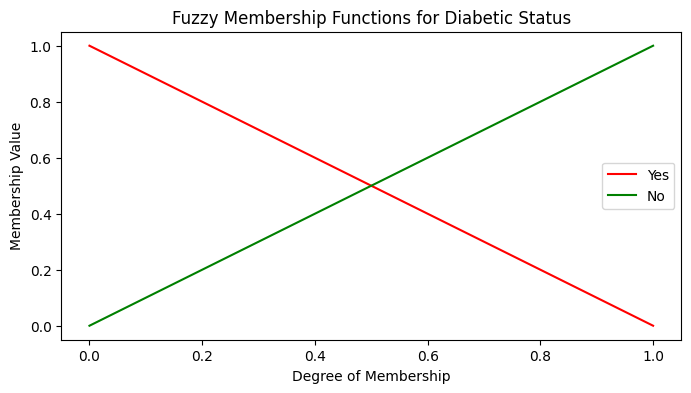

In [15]:
# Melakukan pendefinisian terhadap membership diabetic status
diabetic_universe = np.arange(0, 2, 1)

diabetic = fuzz.trimf(diabetic_universe, [0, 0, 1])
non_diabetic = fuzz.trimf(diabetic_universe, [0, 1, 1])
def diabetic_membership(diabetic_status):
  diabetic_status['Yes'] = fuzz.trimf(diabetic_universe, [0, 0, 1])
  diabetic_status['No'] = fuzz.trimf(diabetic_universe, [0, 1, 1])

# Visualisasi membership
plt.figure(figsize=(8, 4))

plt.plot(diabetic_universe, diabetic, 'r', linewidth=1.5, label='Yes')
plt.plot(diabetic_universe, non_diabetic, 'g', linewidth=1.5, label='No')

plt.title('Fuzzy Membership Functions for Diabetic Status')
plt.xlabel('Degree of Membership')
plt.ylabel('Membership Value')
plt.legend(loc='best')
plt.show()

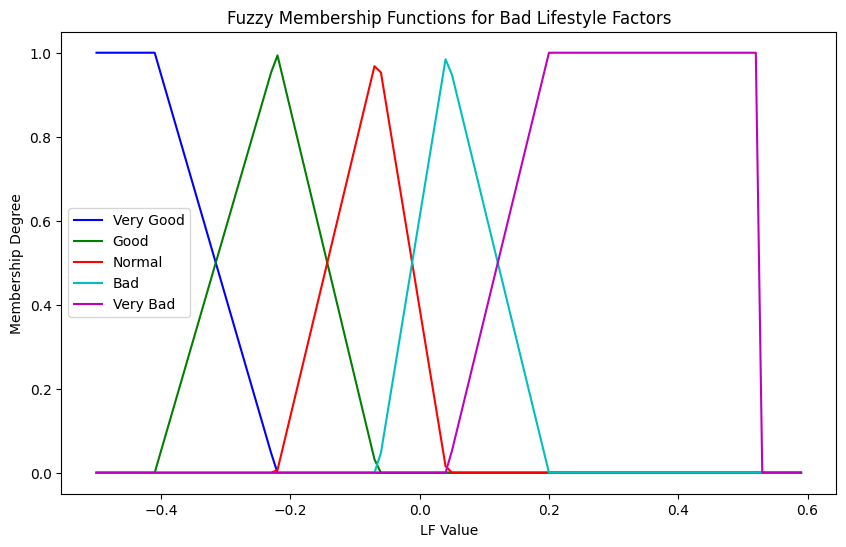

In [16]:
# Melakukan pendefinisian terhadap membership lifestyle
lf_universe = np.arange(-0.5, 0.6, 0.01) #inisiasi semesta fuzzy berdasarkan distribusi data
very_good = fuzz.trapmf(lf_universe, [-0.5, -0.5, -0.41, -0.221])  # Membership fuzzy very_good dengan tipe trapezoidal
good = fuzz.trimf(lf_universe, [-0.41, -0.221, -0.065])  # Membership fuzzy good dengan tipe triangular
normal = fuzz.trimf(lf_universe, [-0.221, -0.065, 0.041667])  # Membership fuzzy normal dengan tipe triangular
bad = fuzz.trimf(lf_universe, [-0.065, 0.041667, 0.2])  # Membership fuzzy bad dengan tipe triangular
very_bad = fuzz.trapmf(lf_universe, [0.041667, 0.2, 0.525, 0.525])  # Membership fuzzy very_bad dengan tipe trapezoidal

def lifestyle_membership(lifestyle):
  lifestyle['Very Good'] = fuzz.trapmf(lf_universe, [-0.5, -0.5, -0.41, -0.221])  # Membership fuzzy very_good dengan tipe trapezoidal
  lifestyle['Good'] = fuzz.trimf(lf_universe, [-0.41, -0.221, -0.065])  # Membership fuzzy good dengan tipe triangular
  lifestyle['Normal'] = fuzz.trimf(lf_universe, [-0.221, -0.065, 0.041667])  # Membership fuzzy normal dengan tipe triangular
  lifestyle['Bad'] = fuzz.trimf(lf_universe, [-0.065, 0.041667, 0.2])  # Membership fuzzy bad dengan tipe triangular
  lifestyle['Very Bad'] = fuzz.trapmf(lf_universe, [0.041667, 0.2, 0.525, 0.525])  # Membership fuzzy very_bad dengan tipe trapezoidal



# Visualisasi membership fuzzy
plt.figure(figsize=(10, 6))

plt.plot(lf_universe, very_good, 'b', linewidth=1.5, label='Very Good')
plt.plot(lf_universe, good, 'g', linewidth=1.5, label='Good')
plt.plot(lf_universe, normal, 'r', linewidth=1.5, label='Normal')
plt.plot(lf_universe, bad, 'c', linewidth=1.5, label='Bad')
plt.plot(lf_universe, very_bad, 'm', linewidth=1.5, label='Very Bad')

plt.title('Fuzzy Membership Functions for Bad Lifestyle Factors')
plt.xlabel('LF Value')
plt.ylabel('Membership Degree')
plt.legend(loc='best')
plt.show()

### B.2.2 Fuzzy Rules

In [20]:
# Melakukan definisi pada input
age = ctrl.Antecedent(np.arange(0, 101, 1), 'Age')
sex = ctrl.Antecedent(np.arange(0, 1.1, 0.1), 'sex')
diabetic_status = ctrl.Antecedent(np.arange(0, 2, 1), 'diabetic')
BMI = ctrl.Antecedent(np.arange(0, 61, 0.1), 'bmi')
glucose = ctrl.Antecedent(np.arange(0, 501, 1), 'glucose')
systolic_pressure = ctrl.Antecedent(np.arange(0, 181, 1), 'systolic')
diastolic_pressure = ctrl.Antecedent(np.arange(0, 121, 1), 'diastolic')
ldl_cholesterol = ctrl.Antecedent(np.arange(0, 301, 1), 'ldl_cholesterol')
smoking_history = ctrl.Antecedent(np.arange(0, 2, 1), 'smoking_history')
lifestyle = ctrl.Antecedent(np.arange(-0.5, 0.6, 0.01), 'lifestyle')

In [21]:
# Melakukan implementasi membership
age_membership(age)
sex_membership(sex)
diabetic_membership(diabetic_status)
bmi_membership(BMI)
glucose_membership(glucose)
systolic_membership(systolic_pressure)
diastolic_membership(diastolic_pressure)
cholesterol_membership(ldl_cholesterol)
smoke_membership(smoking_history)
lifestyle_membership(lifestyle)

In [22]:
# Melakukan pengembangan fuzzy rules dengan kombinasi pendekatan divide and conquer dan fuzzy rules interpolation (kasus extreme)
# Rule 1 : merupakan kombinasi set fuzzy rule dengan faktor risiko utama penyakit kardiovaskular

# Mendefinisikan output dari cardio risk
cardio_risk = ctrl.Consequent(np.arange(0, 11, 1), 'cardio_risk')
cardio_risk['low'] = fuzz.trimf(cardio_risk.universe, [0, 0, 2])
cardio_risk['normal'] = fuzz.trimf(cardio_risk.universe, [2, 4, 6])
cardio_risk['high'] = fuzz.trimf(cardio_risk.universe, [5, 7, 8])
cardio_risk['very high'] = fuzz.trimf(cardio_risk.universe, [8, 10, 10])

# Mendefinisikan aturan fuzzy untuk cardio risk
cardio_rules = [
    # Kondisi untuk kasus dengan risk level : very high
    ctrl.Rule(diabetic_status['Yes'] & (systolic_pressure['Very High']| systolic_pressure['High']) & (diastolic_pressure['High'] | diastolic_pressure['Very High']) & (ldl_cholesterol['Alert']|ldl_cholesterol['High']|ldl_cholesterol['Very High']) , cardio_risk['very high']),
    ctrl.Rule(diabetic_status['No'] & systolic_pressure['Very High'] & (diastolic_pressure['High'] | diastolic_pressure['Very High']) & ldl_cholesterol['Very High'] , cardio_risk['very high']),

    # Kondisi untuk kasus dengan risk level : low
    ctrl.Rule(diabetic_status['Yes'] & systolic_pressure['Normal'] & diastolic_pressure['Normal'] & ldl_cholesterol['Normal'] , cardio_risk['low']),
    ctrl.Rule(diabetic_status['No'] & (systolic_pressure['Normal']| systolic_pressure['Alert']) & (diastolic_pressure['Normal'] | diastolic_pressure['Alert']) & (ldl_cholesterol['Moderate']|ldl_cholesterol['Normal']) , cardio_risk['low']),

    # Kondisi untuk kasus dengan risk level: high
    ctrl.Rule(diabetic_status['Yes'] & systolic_pressure['High'] & diastolic_pressure['High'] & ldl_cholesterol['Moderate'] , cardio_risk['high']),
    ctrl.Rule(diabetic_status['Yes'] & systolic_pressure['Alert'] & diastolic_pressure['Alert'] & ldl_cholesterol['Alert'] , cardio_risk['high']),
    ctrl.Rule(diabetic_status['Yes'] & systolic_pressure['Alert'] & diastolic_pressure['Alert'] & ldl_cholesterol['Moderate'] , cardio_risk['high']),
    ctrl.Rule(diabetic_status['No'] & systolic_pressure['High'] & diastolic_pressure['High'] & ldl_cholesterol['High'] , cardio_risk['high']),

    # Kondisi untuk kasus dengan risk level: normal
    ctrl.Rule(diabetic_status['Yes'] & systolic_pressure['Normal'] & diastolic_pressure['Normal'] & ldl_cholesterol['Alert'] , cardio_risk['normal'])
]


In [23]:
# Rule 2 : merupakan kombinasi set fuzzy rule dengan faktor risiko lifestyle

# Mendefinisikan output dari lifestyle risk
lifestyle_risk = ctrl.Consequent(np.arange(0, 11, 1), 'lifestyle_risk')
lifestyle_risk['low'] = fuzz.trimf(lifestyle_risk.universe, [0, 0, 2])
lifestyle_risk['normal'] = fuzz.trimf(lifestyle_risk.universe, [2, 4, 6])
lifestyle_risk['high'] = fuzz.trimf(lifestyle_risk.universe, [5, 7, 8])
lifestyle_risk['very high'] = fuzz.trimf(lifestyle_risk.universe, [8, 10, 10])

# Mendefinisikan aturan fuzzy untuk cardio risk
lifestyle_rules =[
    #Kondisi untuk kasus dengan risk level : very high
    ctrl.Rule(smoking_history['Smoker'] & (lifestyle['Very Bad'] | lifestyle['Bad']) & (glucose['High']| glucose['Very High']) & (BMI['Moderate Obesity']| BMI['Severe Obesity']), lifestyle_risk['very high']),
    ctrl.Rule(smoking_history['Non-Smoker'] & (lifestyle['Very Bad'] | lifestyle['Bad']) & (glucose['High']| glucose['Very High']) & (BMI['Moderate Obesity']| BMI['Severe Obesity']), lifestyle_risk['very high']),

    #Kondisi untuk kasus dengan risk level : low
    ctrl.Rule(smoking_history['Smoker'] & lifestyle['Very Good'] & glucose['Low'] & (BMI['Underweight']| BMI['Normal']), lifestyle_risk['low']),
    ctrl.Rule(smoking_history['Non-Smoker'] & (lifestyle['Very Good'] | lifestyle['Good'] | lifestyle['Normal']) & (glucose['Low']| glucose['Normal']) & (BMI['Underweight']| BMI['Normal']), lifestyle_risk['low']),

     # Kondisi untuk kasus dengan risk level: high
    ctrl.Rule(smoking_history['Smoker'] & lifestyle['Normal'] & glucose['High'] & (BMI['Mild Obesity']|BMI['Moderate Obesity']|BMI['Severe Obesity']) , lifestyle_risk['high']),
    ctrl.Rule(smoking_history['Smoker'] & lifestyle['Bad'] & glucose['High'] & (BMI['Overweight']| BMI['Mild Obesity']) , lifestyle_risk['high']),
    ctrl.Rule(smoking_history['Smoker'] & lifestyle['Good'] & (glucose['High']|glucose['Normal']) & (BMI['Moderate Obesity']|BMI['Severe Obesity']) , lifestyle_risk['high']),
    ctrl.Rule(smoking_history['Non-Smoker'] & (lifestyle['Normal']|lifestyle['Good']) & glucose['High'] & (BMI['Moderate Obesity']|BMI['Severe Obesity']) , lifestyle_risk['high']),

    # Kondisi untuk kasus dengan risk level: normal
    ctrl.Rule(smoking_history['Smoker'] & lifestyle['Good'] & glucose['Normal'] & (BMI['Underweight']| BMI['Normal']|BMI['Overweight']) , lifestyle_risk['normal']),
    ctrl.Rule(smoking_history['Smoker'] & lifestyle['Normal'] & (glucose['Low']| glucose['Normal']|glucose['Alert']) & (BMI['Underweight']| BMI['Normal']|BMI['Overweight']) , lifestyle_risk['normal']),
    ctrl.Rule(smoking_history['Non-Smoker'] & lifestyle['Normal'] & (glucose['Low']| glucose['Normal']|glucose['Alert']) & (BMI['Underweight']| BMI['Normal']|BMI['Overweight']) , lifestyle_risk['normal']),
]

In [24]:
# Rule 3 : merupakan kombinasi set fuzzy rule dengan faktor risiko lifestyle

# Mendefinisikan output dari demographic risk
demographic_risk = ctrl.Consequent(np.arange(0, 11, 1), 'demographic_risk')
demographic_risk['low'] = fuzz.trimf(demographic_risk.universe, [0, 0, 2])
demographic_risk['normal'] = fuzz.trimf(demographic_risk.universe, [2, 4, 6])
demographic_risk['high'] = fuzz.trimf(demographic_risk.universe, [5, 7, 8])
demographic_risk['very high'] = fuzz.trimf(demographic_risk.universe, [8, 10, 10])

# Mendefinisikan aturan fuzzy untuk cardio risk
demographic_rules =[
    #Kondisi untuk kasus dengan risk level : very high
    ctrl.Rule(sex['Male'] & (age['Old']| age['Adult']), demographic_risk['very high']),
    ctrl.Rule(sex['Female'] & age['Old'], demographic_risk['very high']),

    #Kondisi untuk kasus dengan risk level : low
    ctrl.Rule(sex['Male'] & age['Young'], demographic_risk['low']),
    ctrl.Rule(sex['Female'] & (age['Young']), demographic_risk['low']) ,

    #Kondisi untuk kasus dengan risk level : high
    ctrl.Rule(sex['Male'] & age['Young Adult'], demographic_risk['high']),
    ctrl.Rule(sex['Female'] & age['Adult'], demographic_risk['high']),

    #Kondisi untuk kasus dengan risk level : normal
     ctrl.Rule(sex['Female'] & age['Young Adult'], demographic_risk['normal'])

]

In [25]:
# Melakukan definisi pada output
risk_level = ctrl.Consequent(np.arange(0, 101, 1), 'risk_level')
risk_level['Low Risk'] = fuzz.trimf(risk_level.universe, [0, 10, 20])
risk_level['Moderate Risk'] = fuzz.trimf(risk_level.universe, [15, 25, 40])
risk_level['Alert Risk'] = fuzz.trimf(risk_level.universe, [35, 50, 70])
risk_level['High Risk'] = fuzz.trimf(risk_level.universe, [55, 67.5, 80])
risk_level['Very High Risk'] = fuzz.trimf(risk_level.universe, [70, 85, 100])

In [27]:
def apply_custom_final_fuzzy_rules(cardio_output, lifestyle_output, demographic_output):
    # Fungsi untuk memetakan nilai ke kategori V, H, N, L
    def map_value_to_category(value):
      if value >= 8:# Very High case
        return 'V.H'
      elif 6 <= value < 8:# High case
        return 'H'
      elif 2 <= value < 6: # Normal Case
        return 'N'
      elif 0 <= value < 2: # Low Case
        return 'L'

    # Map nilai cardio, lifestyle, dan demographic ke kategori
    cardio_category = map_value_to_category(cardio_output)
    lifestyle_category = map_value_to_category(lifestyle_output)
    demographic_category = map_value_to_category(demographic_output)


    # Klasifikasi integrasi sub-rules dengan kombinasi dari output tiap sub-rule
    combination = f"{cardio_category} and {lifestyle_category} and {demographic_category}"
    very_high = [
       'V.H and V.H and V.H', 'V.H and V.H and H', 'V.H and V.H and N','V.H and H and V.H',
       'V.H and H and H', 'V.H and H and N','V.H and N and V.H','V.H and N and H',
       'V.H and N and N', 'V.H and L and V.H', 'V.H and L and H', 'V.H and L and N',
       'H and V.H and V.H', 'H and V.H and H', 'H and V.H and N', 'H and H and V.H',
       'H and H and H'
    ]

    high = [
        'V.H and V.H and L','V.H and H and L','V.H and N and L', 'V.H and L and L',
        'H and V.H and L', 'H and H and N', 'H and H and L', 'H and N and V.H',
        'H and N and H', 'H and L and V.H', 'N and V.H and V.H'
    ]

    allow = [
        'H and N and N', 'H and N and L','H and L and N','H and L and L',
        'N and V.H and H', 'N and V.H and N','N and H and V.H','N and H and H',
        'N and N and V.H','N and N and H','L and V.H and V.H','L and V.H and H',
        'L and H and V.H',
    ]

    moderate =[
        'N and H and N','N and H and L','N and L and V.H', 'N and V.H and L',
        'N and L and H','L and V.H and N','L and V.H and L', 'L and H and H',
        'L and H and N','L and N and V.H', 'L and N and H','L and L and V.H',
        'L and L and H'
    ]

    low = [
        'N and N and N','N and N and L', 'N and L and N', 'N and L and L',
        'L and H and L','N and L and L', 'L and N and N', 'L and N and L ', 'L and L and N',
        'L and L and N', 'L and L and L'
    ]

    if combination in very_high: final_risk = 'Very High Risk'
    elif combination in high:
      final_risk = 'High Risk'
    elif combination in alert:
      final_risk = 'Alert Risk'
    elif combination in moderate:
      final_risk = 'Moderate Risk'
    elif combination in low:
      final_risk = 'Low Risk'
    else:
      final_risk = 'Unknown Risk'
    return final_risk

### B.2.3 Sistem Inferensi Fuzzy

In [ ]:
def fuzzy_inference(df):
    cardio_risk_simulation = define_cardio_fuzzy_system()
    lifestyle_risk_simulation = define_lifestyle_fuzzy_system()
    demographic_risk_simulation = define_demographic_fuzzy_system()
    level_risk = []
    for index, row in df.iterrows():
      # Sub Aturan 1 : Cardiovascular Inti
      cardio_risk_simulation.input['diabetic_status'] = row.get('Diabetes_diagnose', 'Passed')
      cardio_risk_simulation.input['systolic_pressure'] = row.get('Systolic_pressure', 'Passed')
      cardio_risk_simulation.input['diastolic_pressure'] = row.get('Diastolic_pressure', 'Passed')
      cardio_risk_simulation.input['ldl_cholesterol'] = row.get('LDL_cholesterol', 'Passed')
      cardio_risk_simulation.compute()
      cardio_risk_output = cardio_risk_simulation.output['cardio_risk']
      # Sub Aturan 2 : Lifestyle
      lifestyle_risk_simulation.input['smoking_history'] = row.get('Smoking_History', 'Passed')
      lifestyle_risk_simulation.input['lifestyle'] = row.get('OtherLifestyle_factors', 'Passed')
      lifestyle_risk_simulation.input['glucose'] = row.get('Glucose', 'Passed')
      lifestyle_risk_simulation.input['BMI'] = row.get('BMI', 'Passed')
      lifestyle_risk_simulation.compute()
      lifestyle_risk_output = lifestyle_risk_simulation.output['lifestyle_risk']
      # Sub Aturan 3 : Demographic
      demographic_risk_simulation.input['sex'] = row.get('Sex', 'Passed')
      demographic_risk_simulation.input['age'] = row.get('Age', 'Passed')
      demographic_risk_simulation.compute()
      demographic_risk_output = demographic_risk_simulation.output['demographic_risk']
      # Apply final fuzzy rules and get the final risk level
      final_risk_level = apply_custom_final_fuzzy_rules(cardio_risk_output, lifestyle_risk_output, demographic_risk_output)
      level_risk.append(final_risk_level)
    df['Cardiovascular_risk_level'] = level_risk
return df

In [ ]:
# Pre-requisite: proses C.1 Data Preparation Dataset 1 : Dataset Inisiial
data_fuzzy = data_final5.copy()
fuzzy_inference(data_fuzzy)

### B.2.4 Import Fuzzy (Dilakukan saat proses fuzzifikasi sudah selesai)

In [ ]:
# Melakukan import dataset fuzzy yang telah melalui proses fuzifikasi
fuzzy = pd.read_csv('data_fuzzy.csv')
fuzzy_clean = fuzzy.copy()

In [ ]:
fuzzy_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42249 entries, 0 to 42248
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        42249 non-null  float64
 1   Sex                        42249 non-null  int64  
 2   BMI                        42249 non-null  float64
 3   Diabetes_diagnose          42249 non-null  int64  
 4   Glucose                    42249 non-null  float64
 5   Systolic_pressure          42249 non-null  float64
 6   Diastolic_pressure         42249 non-null  float64
 7   Smoking_History            42249 non-null  int64  
 8   LDL_cholesterol            42249 non-null  float64
 9   Heart_Disease              42249 non-null  int64  
 10  OtherLifestyle_factors     42249 non-null  float64
 11  Cardiovascular_risk_level  42249 non-null  object 
dtypes: float64(7), int64(4), object(1)
memory usage: 3.9+ MB


In [ ]:
fuzzy_clean['Cardiovascular_risk_level'].value_counts()

Cardiovascular_risk_level
Alert Risk        36619
High Risk          2871
Moderate Risk      1377
Very High Risk     1229
Low Risk            153
Name: count, dtype: int64

In [ ]:
# Melakukan teknik encoding data pada data fuzzy, khususnya pada fitur level risiko penyakit kardiovaskular
risk_mapping = {
    'Low Risk': 0,
    'Moderate Risk': 1,
    'Alert Risk': 2,
    'High Risk': 3,
    'Very High Risk' : 4
}
fuzzy_clean['encoded'] = fuzzy_clean['Cardiovascular_risk_level'].map(risk_mapping)

In [ ]:
fuzzy_clean['encoded'].value_counts()

encoded
2    36619
3     2871
1     1377
4     1229
0      153
Name: count, dtype: int64

## **B.3 Proses Eksplorasi Analisis Data**

### B.3.1 EDA pada Dataset Inisial

In [ ]:
data_final2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42249 entries, 0 to 42248
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Age                           42249 non-null  object 
 1   Sex                           42249 non-null  object 
 2   BMI                           42249 non-null  float64
 3   Diabetes_diagnose             42249 non-null  object 
 4   Glucose                       42249 non-null  float64
 5   HBA1C_Result                  42249 non-null  float64
 6   Systolic_pressure             42249 non-null  float64
 7   Diastolic_pressure            42249 non-null  float64
 8   Smoking_History               42249 non-null  object 
 9   Alcohol_Consumption           42249 non-null  float64
 10  LDL_cholesterol               42249 non-null  float64
 11  VLDL_cholesterol              42249 non-null  float64
 12  Latest_checkup                42249 non-null  object 
 13  H

In [ ]:
print('Latest checkup feature descriptions: \n', data_final2['Latest_checkup'].describe())
print('General health feature descriptions: \n',data_final2['General_Health'].describe())

Latest checkup feature descriptions: 
 count                    42249
unique                       5
top       Within the past year
freq                     38945
Name: Latest_checkup, dtype: object
General health feature descriptions: 
 count     42249
unique        5
top        Good
freq      16576
Name: General_Health, dtype: object


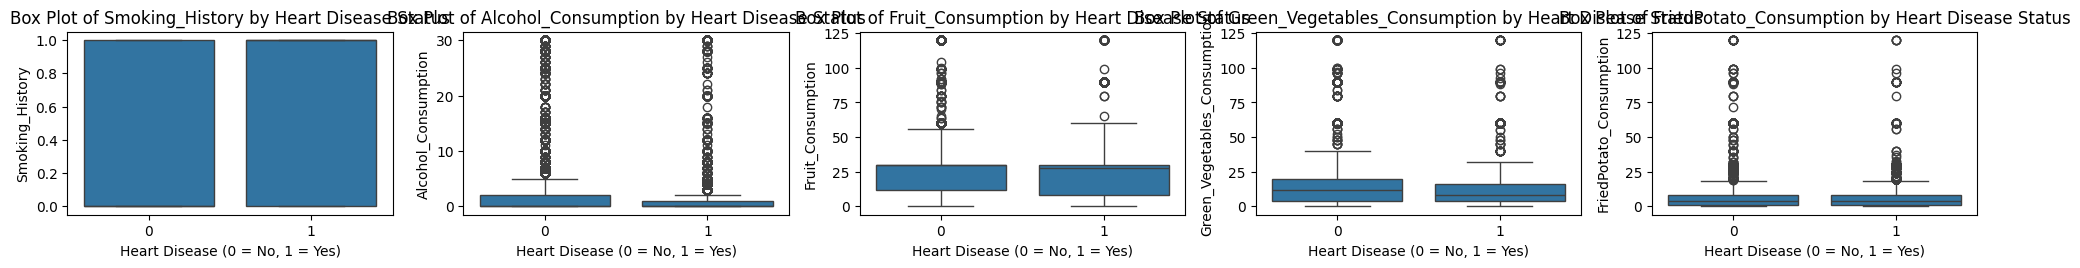

In [ ]:
boxplot = data_final2.copy()

def convert_age_to_numeric(age):
    if '-' in age:
        min_age, max_age = age.split('-')
        return (int(min_age) + int(max_age)) / 2
    elif '<' in age:
        return int(age.replace('<', '')) - 5
    elif '+' in age:
        return int(age.replace('+', '')) + 5
    else:
        return int(age)
boxplot['Heart_Disease'] = boxplot['Heart_Disease'].map({'Yes': 1, 'No': 0})
boxplot['Depression'] = boxplot['Depression'].apply(lambda x: 1 if x == 'Yes' else 0)
boxplot['Diabetes_diagnose'] = boxplot['Diabetes_diagnose'].map({'Yes': 1, 'Yes, but female told only during pregnancy': 0})
boxplot['Smoking_History'] = boxplot['Smoking_History'].apply(lambda x: 1 if x == 'Yes' else 0)
boxplot['Exercise'] = boxplot['Exercise'].apply(lambda x: 1 if x == 'Yes' else 0)
boxplot['Depression'] = boxplot['Depression'].apply(lambda x: 1 if x == 'Yes' else 0)
boxplot['Sex'] = boxplot['Sex'].apply(lambda x: 1 if x =='Female' else 0)
boxplot['Age'] = boxplot['Age'].apply(convert_age_to_numeric)

feature_1= [
    'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption',
    'Green_Vegetables_Consumption', 'FriedPotato_Consumption'
]
feature_2= [
   'Exercise', 'Depression', 'Sex', 'BMI', 'Age', 'Location', 'Diabetes_diagnose'
]

feature_3 = [
    'Latest_checkup', 'General_Health', 'Systolic_pressure',
    'Diastolic_pressure', 'LDL_cholesterol'
]
feature_4 = ['VLDL_cholesterol', 'Glucose', 'HBA1C_Result'
]

plt.figure(figsize=(20, 12))
for i, feature in enumerate(feature_1):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(x='Heart_Disease', y=feature, data=boxplot)
    plt.title(f'Box Plot of {feature} by Heart Disease Status')
    plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

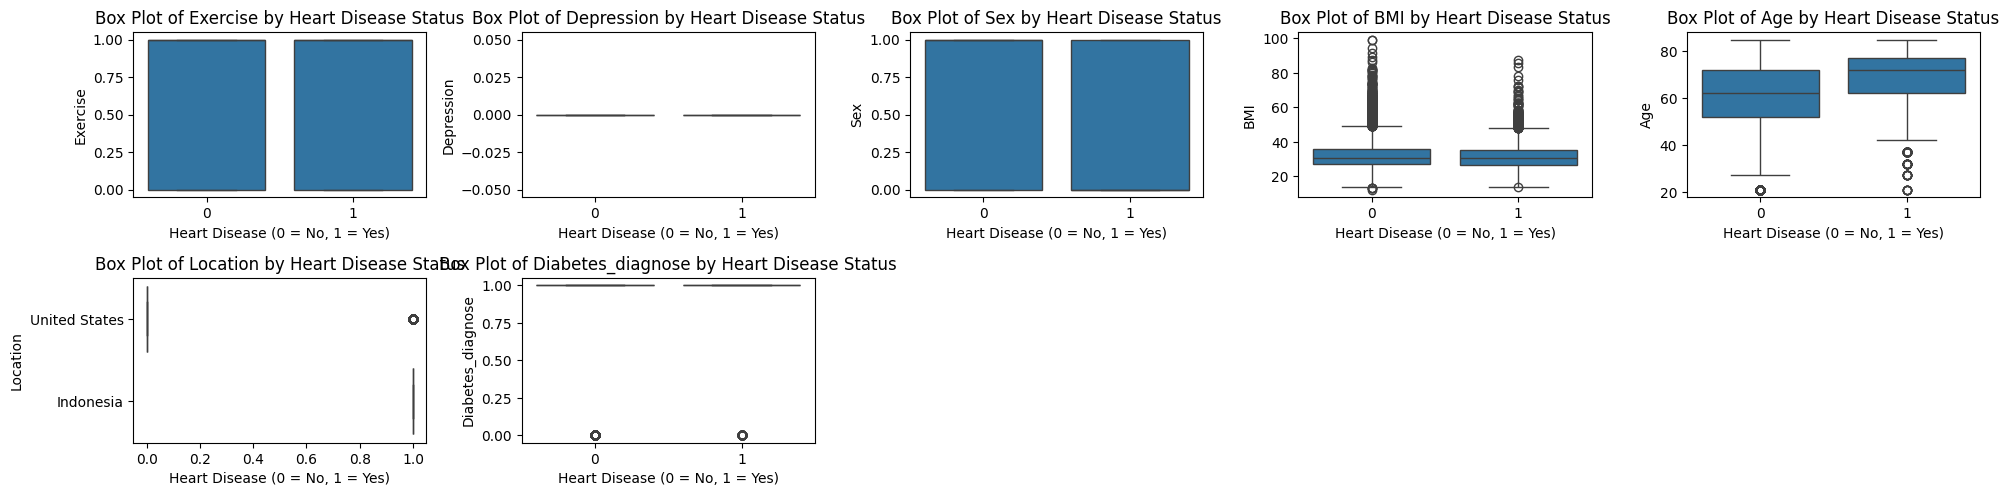

In [ ]:
plt.figure(figsize=(20, 12))
for i, feature in enumerate(feature_2):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(x='Heart_Disease', y=feature, data=boxplot)
    plt.title(f'Box Plot of {feature} by Heart Disease Status')
    plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

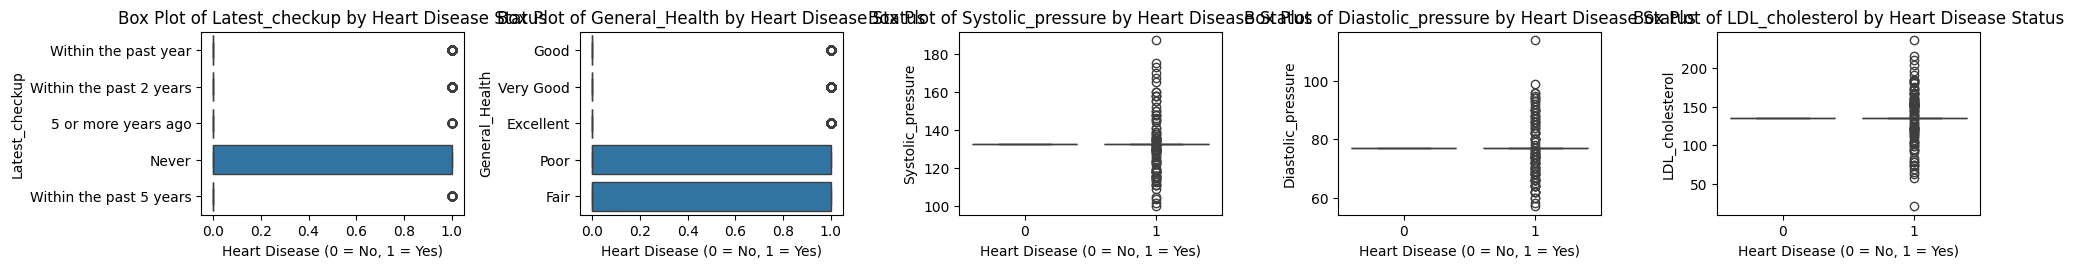

In [ ]:
plt.figure(figsize=(20, 12))
for i, feature in enumerate(feature_3):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(x='Heart_Disease', y=feature, data=boxplot)
    plt.title(f'Box Plot of {feature} by Heart Disease Status')
    plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

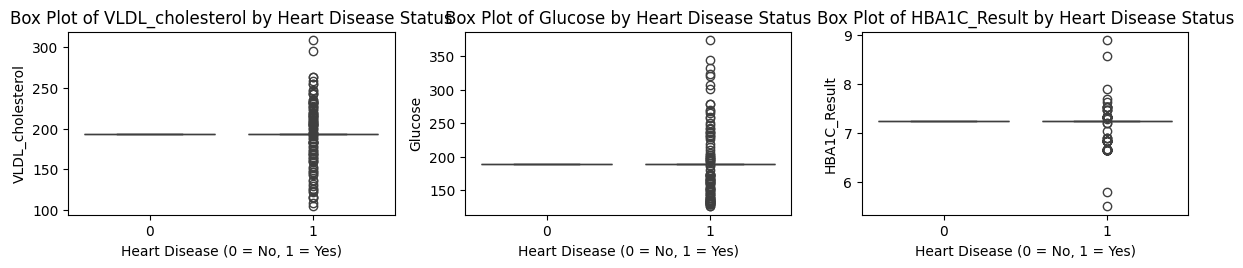

In [ ]:
plt.figure(figsize=(20, 12))
for i, feature in enumerate(feature_4):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(x='Heart_Disease', y=feature, data=boxplot)
    plt.title(f'Box Plot of {feature} by Heart Disease Status')
    plt.xlabel('Heart Disease (0 = No, 1 = Yes)')
plt.tight_layout()
plt.show()

<ipython-input-127-0b9cb413013f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=data_final2["Heart_Disease"], palette=cols)


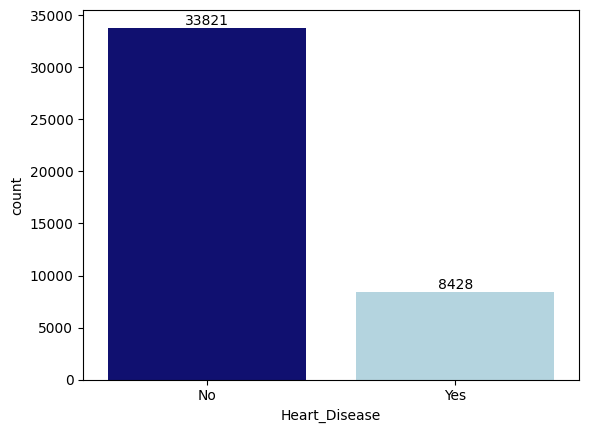

In [ ]:
# Mengevaluasi apakah ada skewness atau imbalance pada data
cols= ["#000080", "#ADD8E6"]
ax = sns.countplot(x=data_final2["Heart_Disease"], palette=cols)
for container in ax.containers:
    ax.bar_label(container)

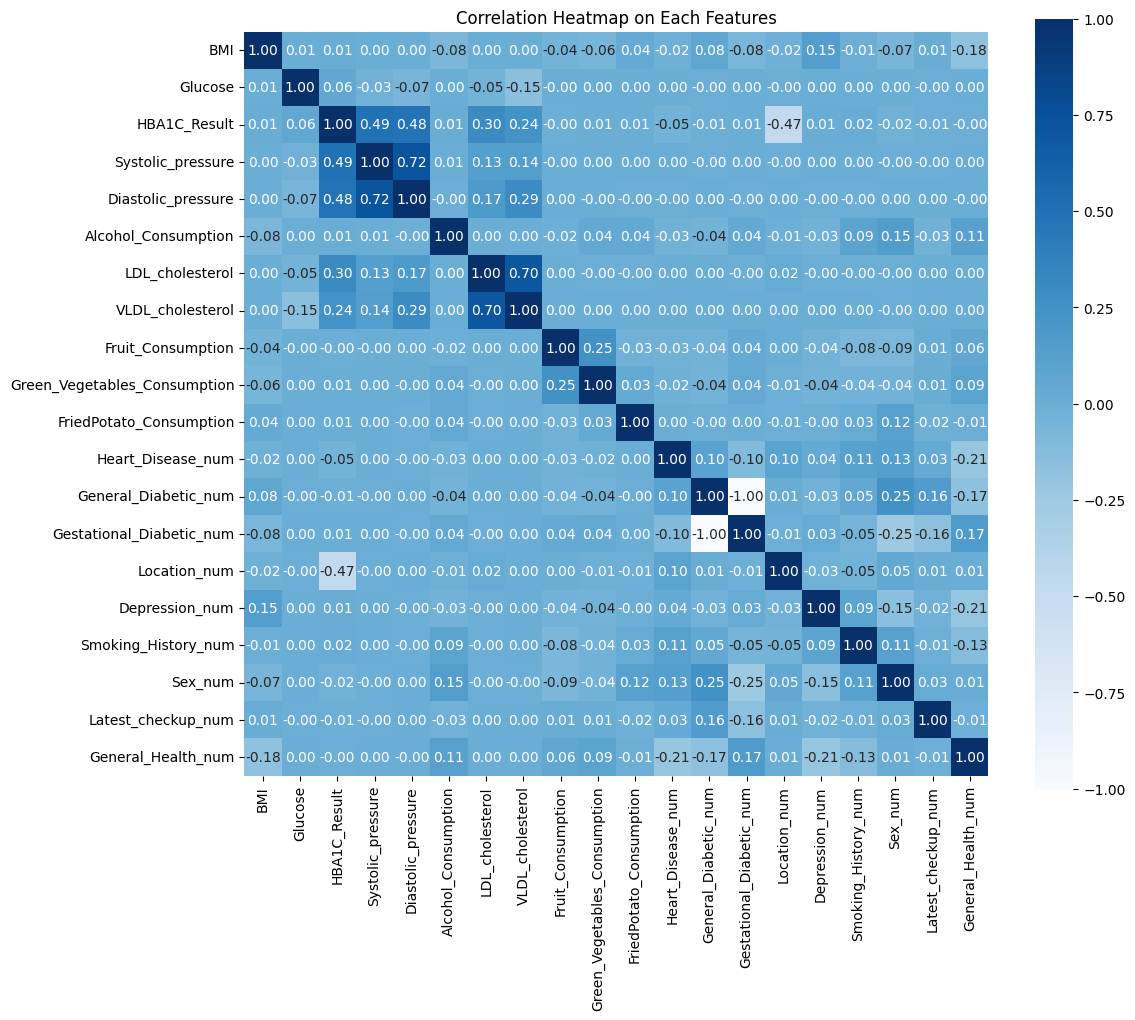

In [ ]:
# Dikarenakan fitur utama pada penelitian merupakan tipe data kategorikal, maka perlu dilakukan perubahan format tipe data
heatmap = data_final2.copy()
heatmap['Heart_Disease_num'] = heatmap['Heart_Disease'].map({'Yes':1, 'No':0})
heatmap['General_Diabetic_num'] = heatmap['Diabetes_diagnose'].apply(lambda x: 1 if x == 'Yes' else 0)
heatmap['Gestational_Diabetic_num'] = heatmap['Diabetes_diagnose'].apply(lambda x: 1 if x == 'Yes, but female told only during pregnancy' else 0)
heatmap['Location_num'] = heatmap['Location'].apply(lambda x: 1 if x == 'United States' else 2)
heatmap['Depression_num'] = heatmap['Depression'].apply(lambda x: 1 if x == 'Yes' else 0)
heatmap['Smoking_History_num'] = heatmap['Smoking_History'].apply(lambda x: 1 if x == 'Yes' else 0)
heatmap['Sex_num'] = heatmap['Sex'].apply(lambda x: 1 if x == 'Female' else 2)
heatmap['Latest_checkup_num'] = heatmap['Latest_checkup'].apply(
    lambda x: 4 if x == 'Within the past year' else
              3 if x == 'Within the past 2 years' else
              2 if x == 'Within the past 5 years' else
              1 if x == '5 or more years ago' else
              0
)
heatmap['General_Health_num'] = heatmap['General_Health'].apply(
    lambda x: 4 if x == 'Excellent' else
              3 if x == 'Very Good'  else
              2 if x == 'Good' else
              1 if x == 'Fair' else
              0
)

correlation_matrix = heatmap.corr(numeric_only=True)

#Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='Blues',
            fmt='.2f',
            square=True)
plt.title('Correlation Heatmap on Each Features')
plt.show()

In [ ]:
print(data_final2['Latest_checkup'].unique())
print(data_final2['General_Health'].unique())

['Within the past year' 'Within the past 2 years' '5 or more years ago'
 'Never' 'Within the past 5 years']
['Good' 'Very Good' 'Excellent' 'Poor' 'Fair']


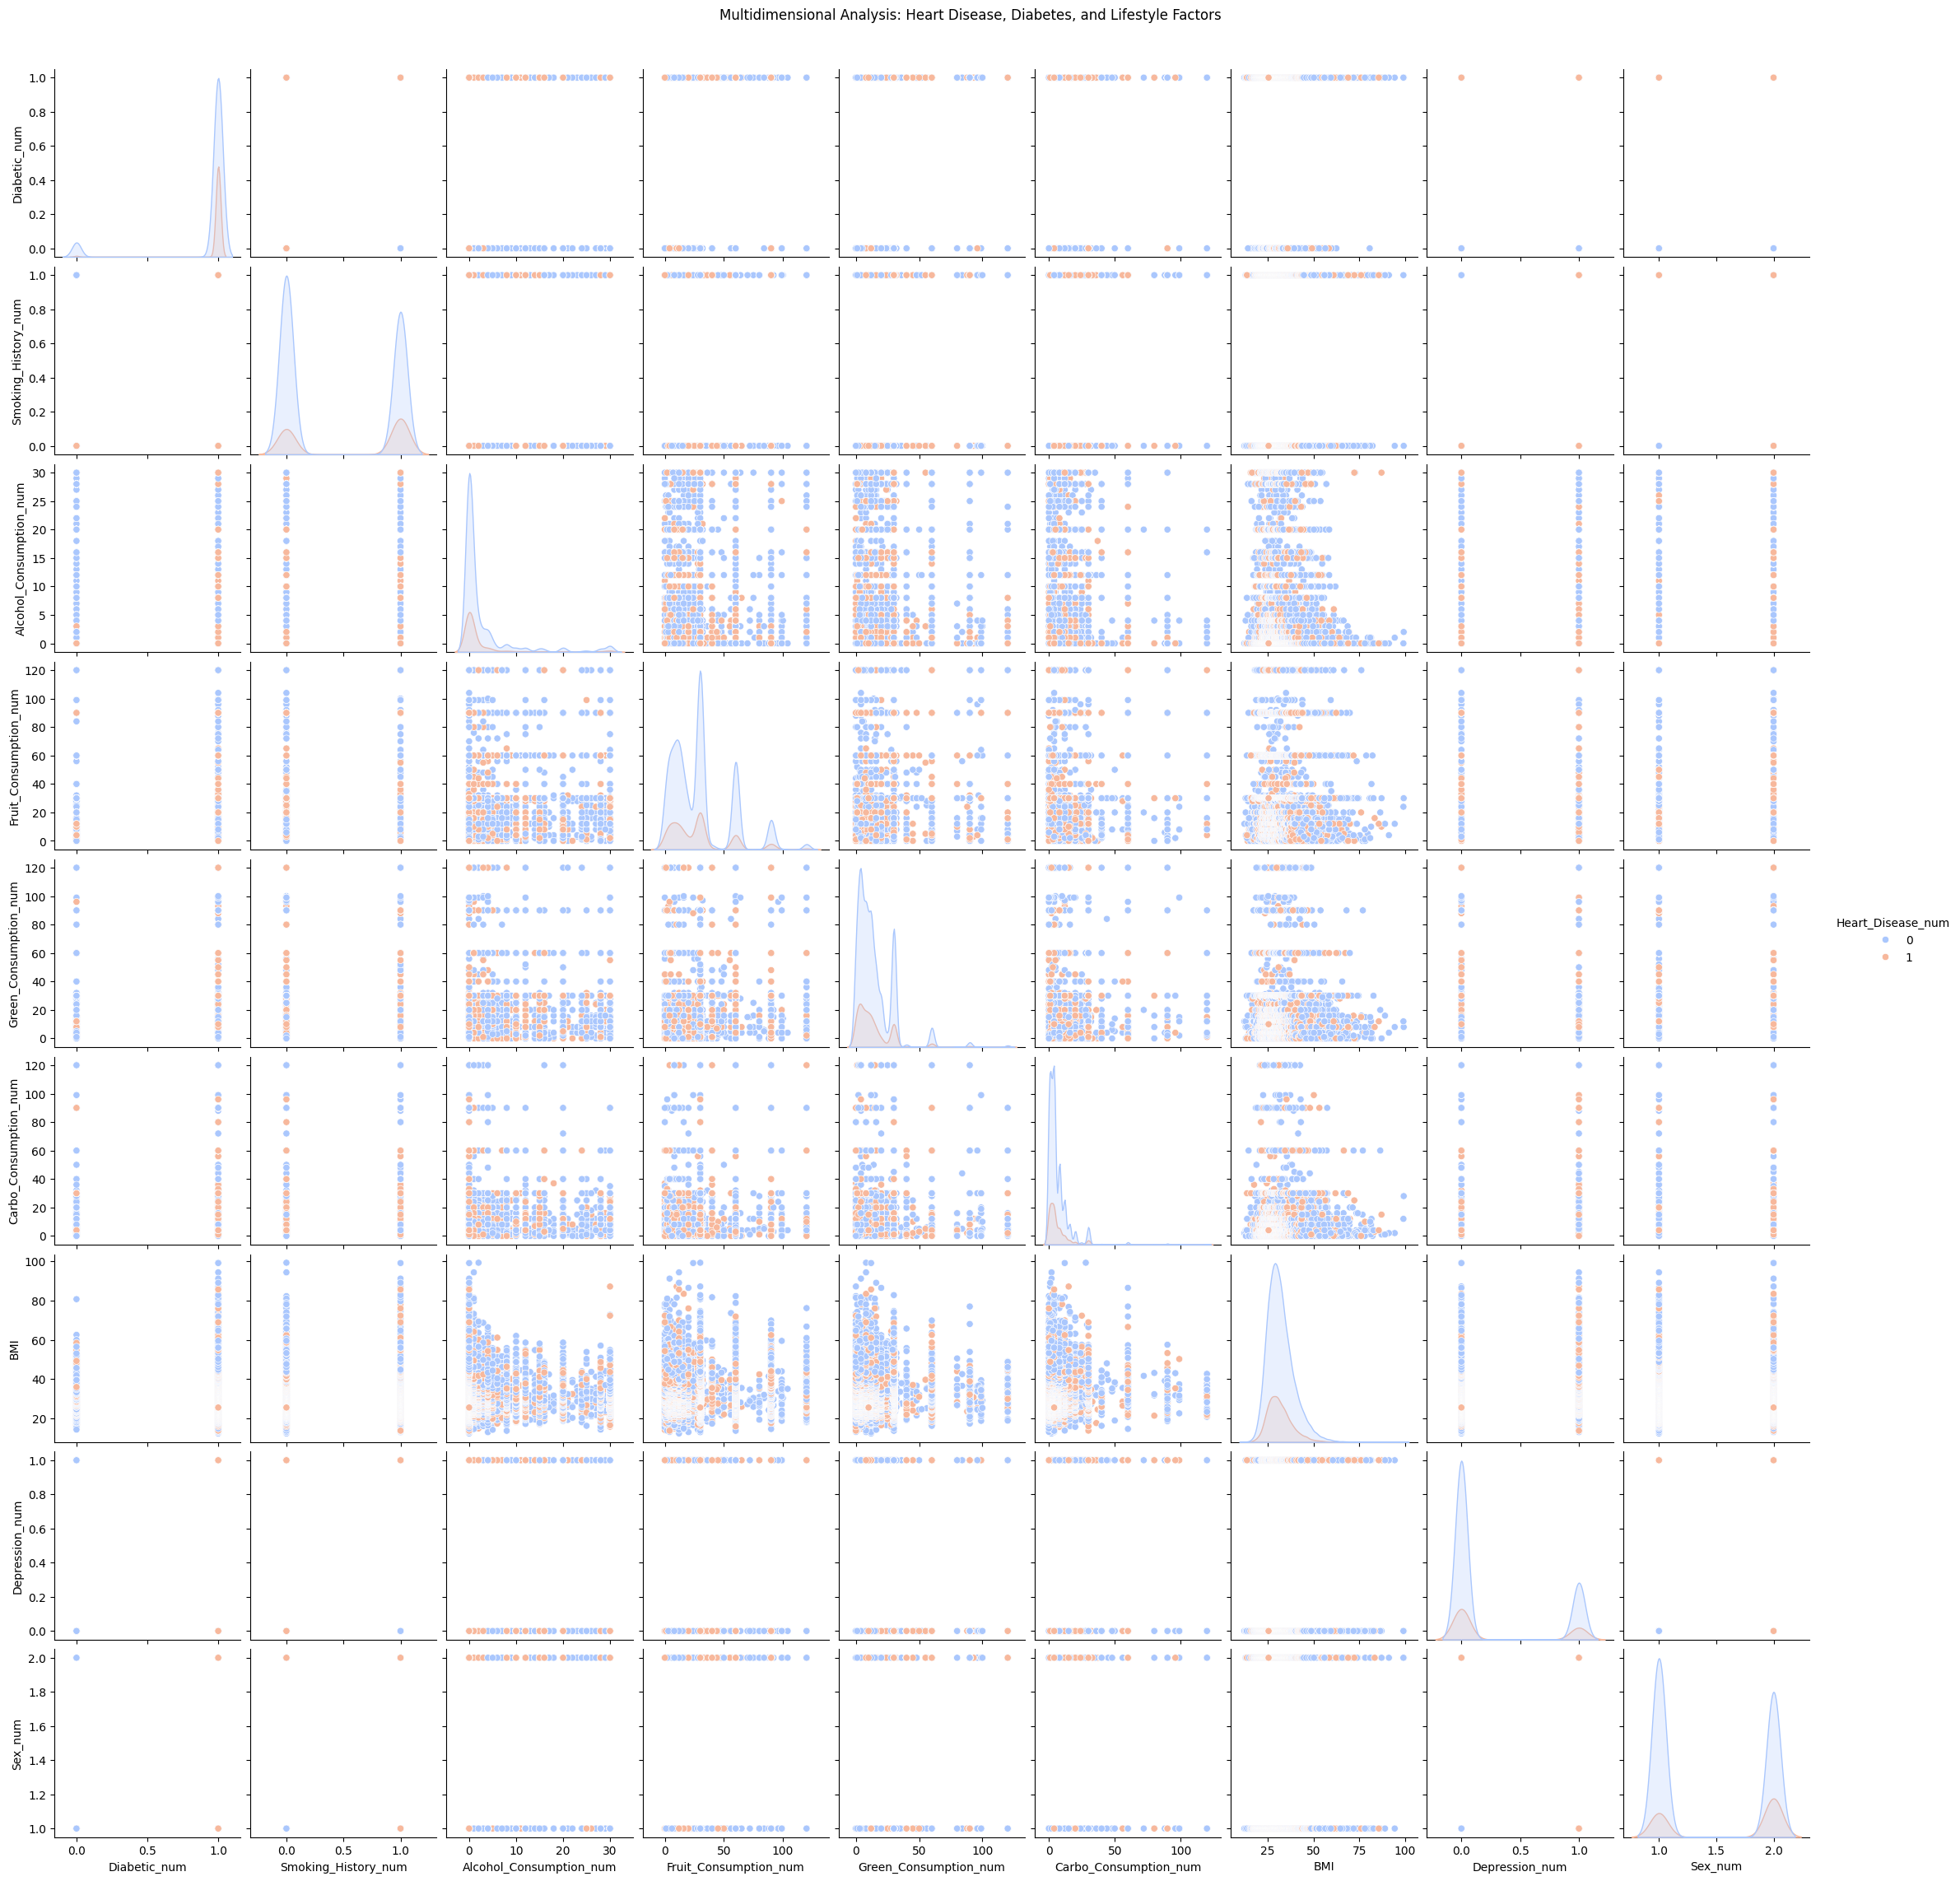

In [ ]:
#Melakukan multidimentional analysis untuk melihat korelasi multidimensi
pairplott = data_final2.copy()

def convert_age_to_numeric(age):
    if '-' in age:
        min_age, max_age = age.split('-')
        return (int(min_age) + int(max_age)) / 2
    elif '<' in age:
        return int(age.replace('<', '')) - 5
    elif '+' in age:
        return int(age.replace('+', '')) + 5
    else:
        return int(age)
#Melakukan konversi data kategorikal lain kepada numeric
pairplott['Heart_Disease_num'] = pairplott['Heart_Disease'].map({'Yes':1, 'No':0})
pairplott['Diabetic_num'] = pairplott['Diabetes_diagnose'].apply(lambda x: 1 if x == 'Yes' else 0)
pairplott['Smoking_History_num'] = pairplott['Smoking_History'].map({'No': 0, 'Yes': 1})
pairplott['Alcohol_Consumption_num'] = pairplott['Alcohol_Consumption'].astype(float)
pairplott['Fruit_Consumption_num'] = pairplott['Fruit_Consumption'].astype(float)
pairplott['Green_Consumption_num'] = pairplott['Green_Vegetables_Consumption'].astype(float)
pairplott['Carbo_Consumption_num'] = pairplott['FriedPotato_Consumption'].astype(float)
pairplott['Age_num'] = pairplott['Age'].apply(convert_age_to_numeric)
pairplott['Depression_num'] = pairplott['Depression'].apply(lambda x: 1 if x == 'Yes' else 0)
pairplott['Sex_num'] = pairplott['Sex'].apply(lambda x: 1 if x =='Female' else 2)

selected_columns = [
    'Heart_Disease_num',
    'Diabetic_num',
    'Smoking_History_num',
    'Alcohol_Consumption_num',
    'Fruit_Consumption_num',
    'Green_Consumption_num',
    'Carbo_Consumption_num',
    'BMI',
    'Age',
    'Depression_num',
    'Sex_num'
]

# Visualisasi
sns.pairplot(pairplott[selected_columns], hue='Heart_Disease_num', palette='coolwarm', diag_kind='kde')
plt.suptitle('Multidimensional Analysis: Heart Disease, Diabetes, and Lifestyle Factors', y=1.02)
plt.show()

### B.3.2 EDA pada Dataset Fuzzy

<ipython-input-148-ec2fe5049db9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=fuzzy_clean["Cardiovascular_risk_level"],order = risk_order, palette=cols)
<ipython-input-148-ec2fe5049db9>:3: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(x=fuzzy_clean["Cardiovascular_risk_level"],order = risk_order, palette=cols)


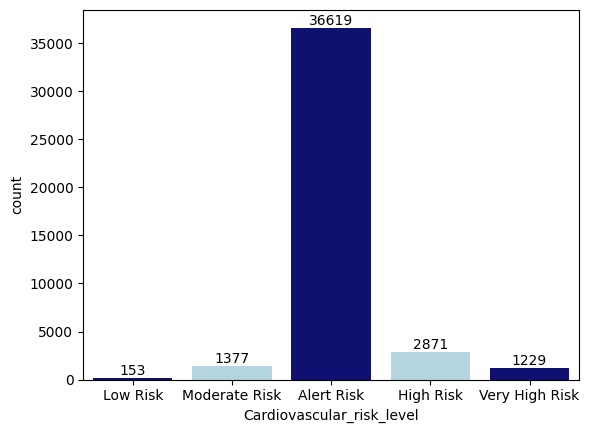

In [ ]:
cols= ["#000080", "#ADD8E6"]
risk_order = ['Low Risk', 'Moderate Risk', 'Alert Risk', 'High Risk', 'Very High Risk']
ax = sns.countplot(x=fuzzy_clean["Cardiovascular_risk_level"],order = risk_order, palette=cols)
for container in ax.containers:
    ax.bar_label(container)

In [ ]:
fuzzy_clean['Cardiovascular_risk_level'].describe()

count          42249
unique             5
top       Alert Risk
freq           36619
Name: Cardiovascular_risk_level, dtype: object

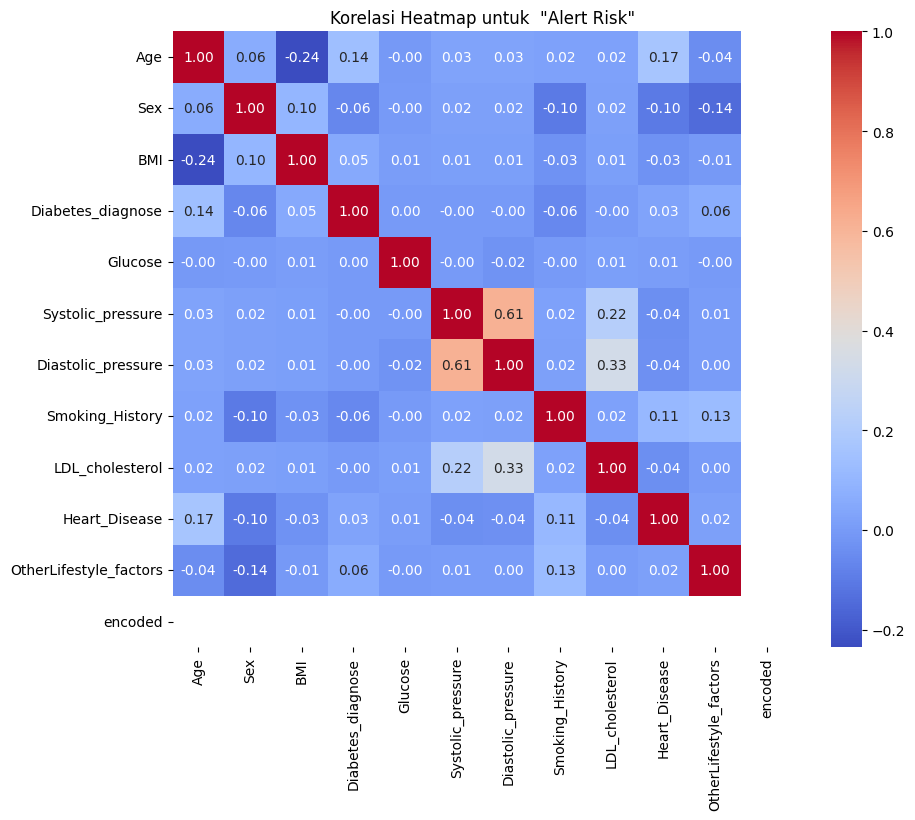

In [ ]:
alert = fuzzy_clean[fuzzy_clean['Cardiovascular_risk_level'] == 'Alert Risk']
other = alert.select_dtypes(include =[np.number])

correlation_matrix = other.corr()

plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Heatmap untuk  "Alert Risk"')
plt.show()

In [ ]:
fuzzy_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42249 entries, 0 to 42248
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        42249 non-null  float64
 1   Sex                        42249 non-null  int64  
 2   BMI                        42249 non-null  float64
 3   Diabetes_diagnose          42249 non-null  int64  
 4   Glucose                    42249 non-null  float64
 5   Systolic_pressure          42249 non-null  float64
 6   Diastolic_pressure         42249 non-null  float64
 7   Smoking_History            42249 non-null  int64  
 8   LDL_cholesterol            42249 non-null  float64
 9   Heart_Disease              42249 non-null  int64  
 10  OtherLifestyle_factors     42249 non-null  float64
 11  Cardiovascular_risk_level  42249 non-null  object 
 12  encoded                    42249 non-null  int64  
dtypes: float64(7), int64(5), object(1)
memory usag

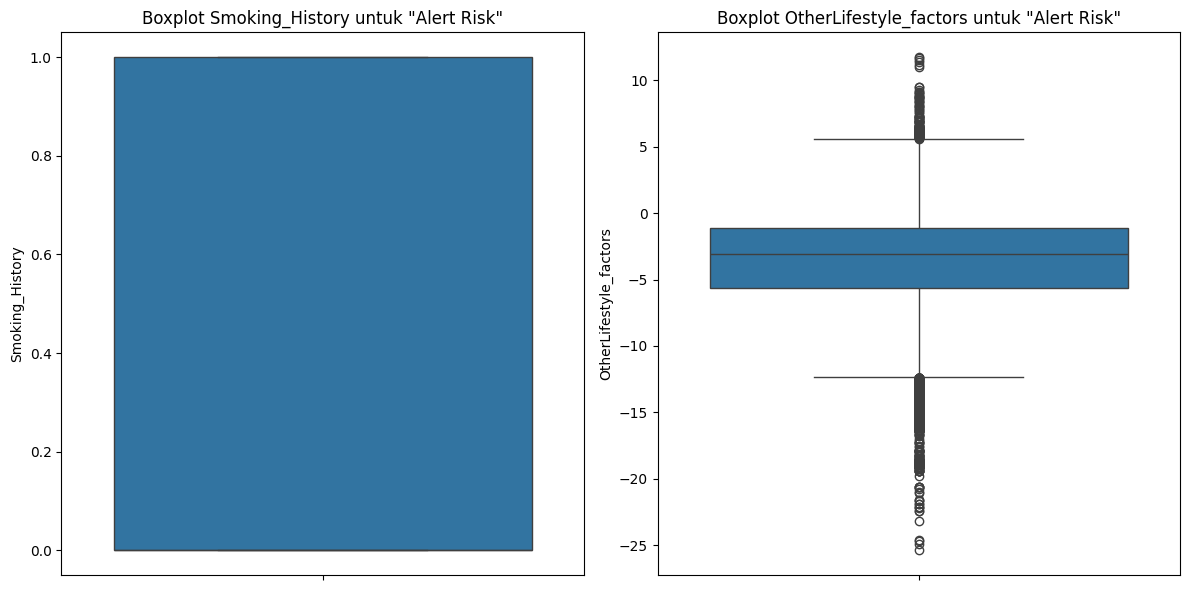

In [ ]:
alert_risk_df = fuzzy_clean[fuzzy_clean['Cardiovascular_risk_level'] == 'Alert Risk']

plt.figure(figsize=(12, 6))

# Visualisasi boxplot untuk Smoking_History
plt.subplot(1, 2, 1)
sns.boxplot(y=alert_risk_df['Smoking_History'])
plt.title('Boxplot Smoking_History untuk "Alert Risk"')

# Visualisasi boxplot untuk OtherLifestyle_factors
plt.subplot(1, 2, 2)
sns.boxplot(y=alert_risk_df['OtherLifestyle_factors'])
plt.title('Boxplot OtherLifestyle_factors untuk "Alert Risk"')

plt.tight_layout()
plt.show()


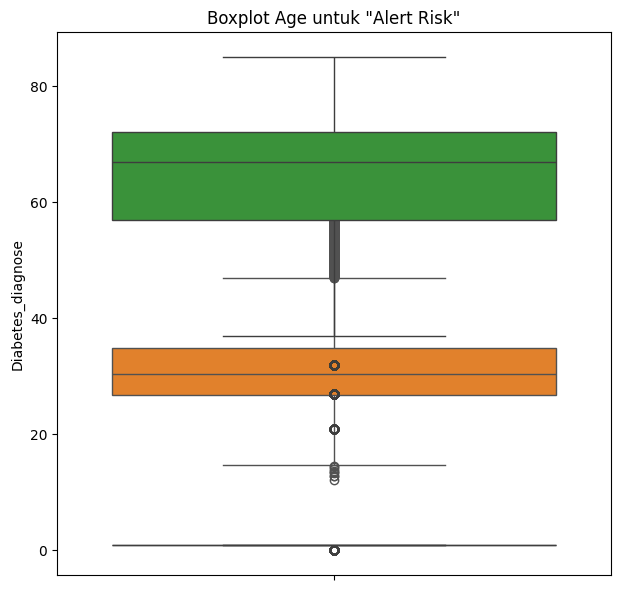

In [ ]:
# Visualisasi boxplot untuk Age
plt.subplot(1, 2, 2)
sns.boxplot(y=alert_risk_df['Age'])
plt.title('Boxplot Age untuk "Alert Risk"')

plt.tight_layout()
plt.show()

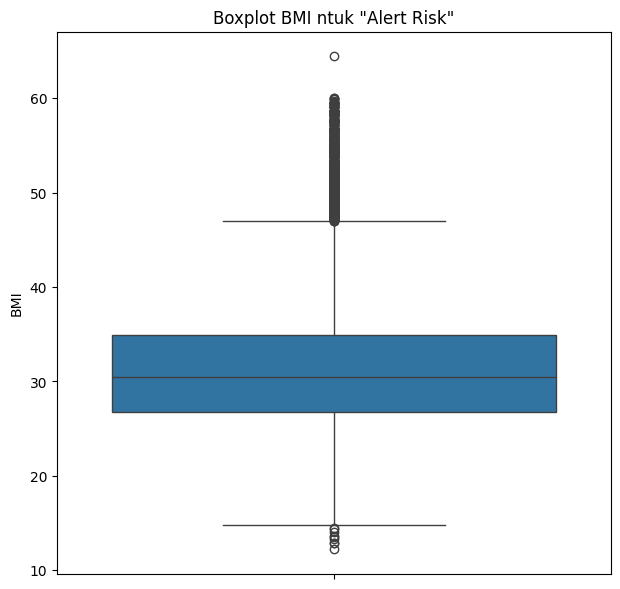

In [ ]:
plt.figure(figsize=(12, 6))
# Visualisasi boxplot untuk Diabetes_diagnose
plt.subplot(1, 2, 2)
sns.boxplot(y=alert_risk_df['BMI'])
plt.title('Boxplot BMI ntuk "Alert Risk"')
plt.tight_layout()
plt.show()

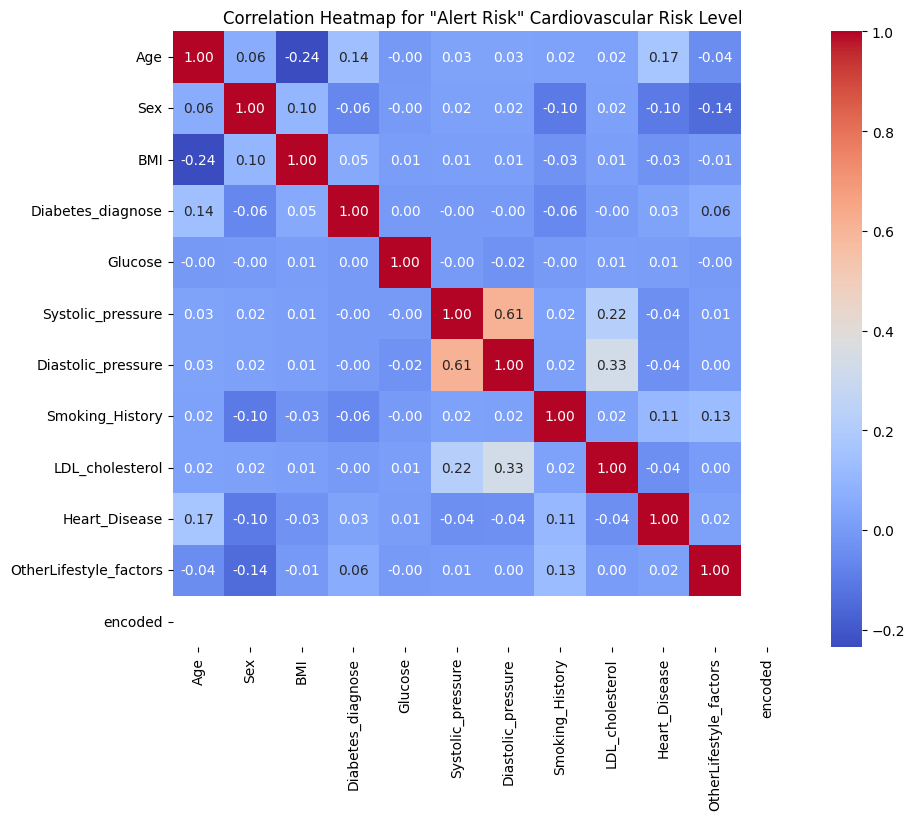

In [ ]:
# Visualisasi pairplot
numerical_columns_alert_risk = alert_risk_df.select_dtypes(include=[float, int])
correlation_matrix_alert_risk = numerical_columns_alert_risk.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_alert_risk, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap for "Alert Risk" Cardiovascular Risk Level')
plt.show()

<Figure size 1000x800 with 0 Axes>

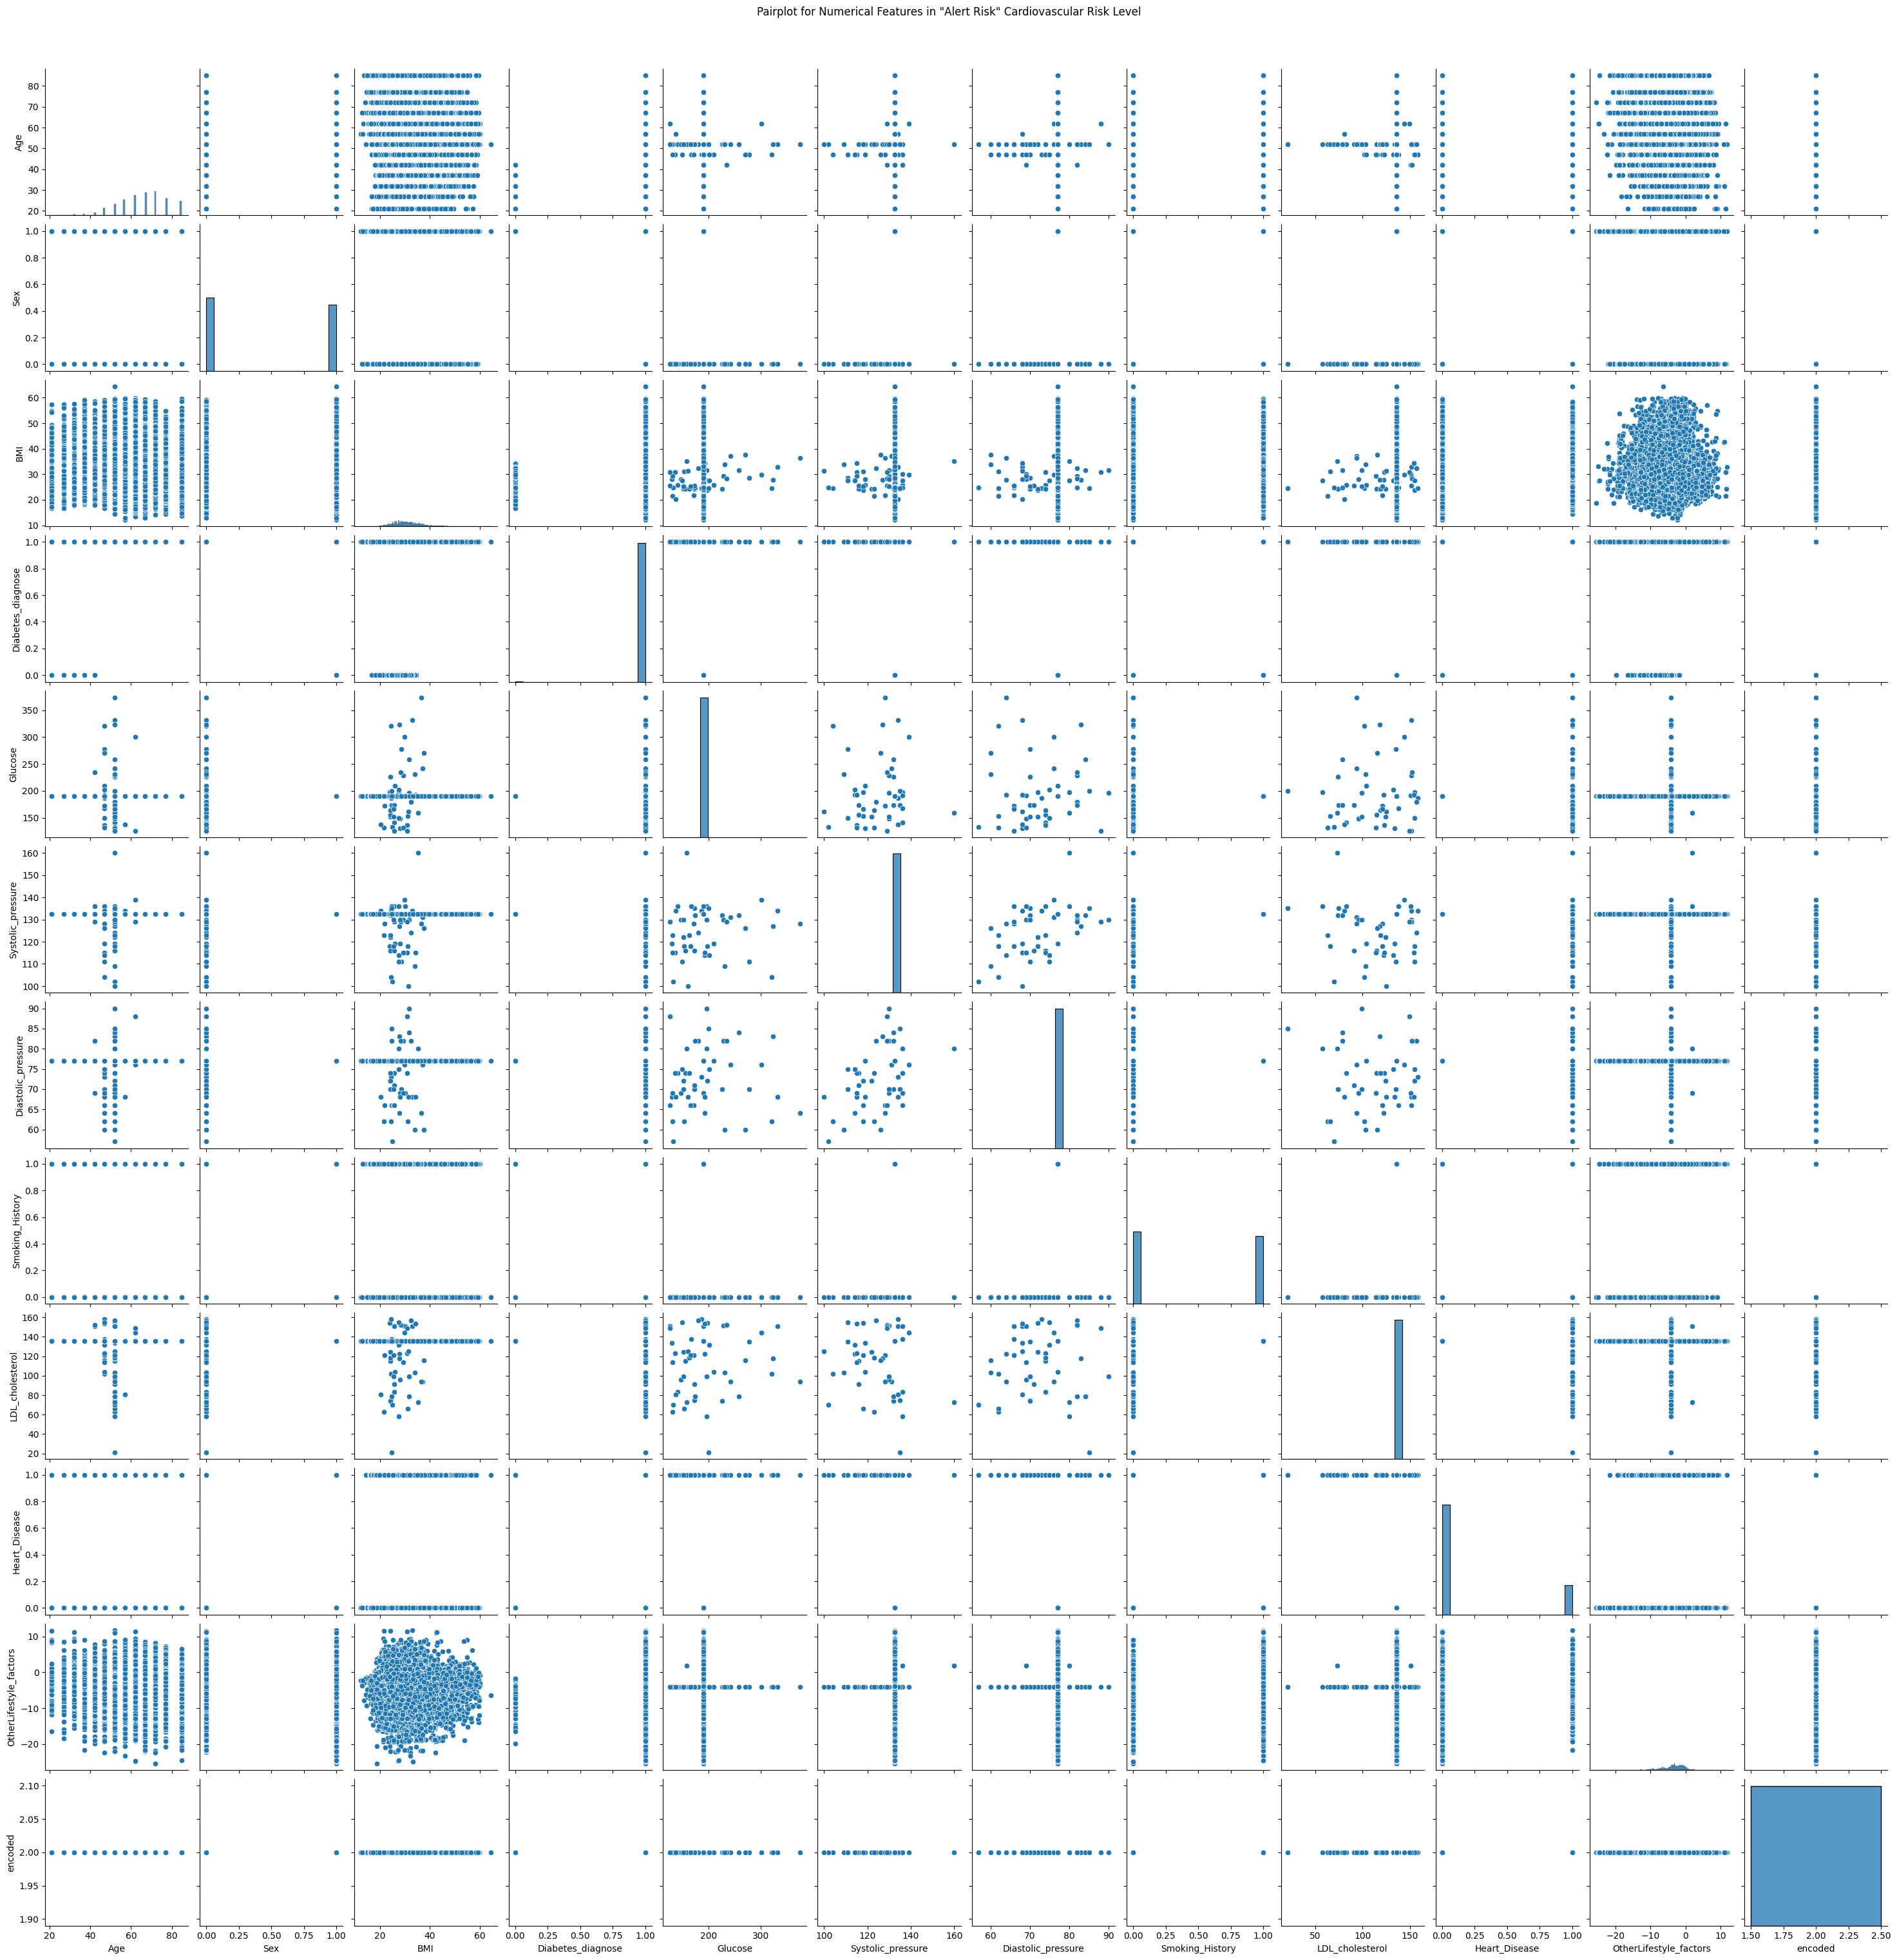

In [ ]:
# Selecting numerical columns for correlation heatmap
numerical_columns_alert_risk = alert_risk_df.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix_alert_risk = numerical_columns_alert_risk.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.pairplot(numerical_columns_alert_risk)
plt.suptitle('Pairplot for Numerical Features in "Alert Risk" Cardiovascular Risk Level', y=1.02)
plt.show()


# **C. Data Preparation**

## C.1. Data Preparation Dataset 1 : Dataset Inisial

In [ ]:
data_final5 = data_final2.copy()

def convert_age_to_numeric(age):
    if age is None:
      return None
    if '-' in age:
        min_age, max_age = age.split('-')
        return (int(min_age) + int(max_age)) / 2
    elif '<' in age:
        return int(age.replace('<', '')) - 5
    elif '+' in age:
        return int(age.replace('+', '')) + 5
    else:
        return int(age)

# Handling features object ke numeric untuk menjaga konsistensi data
data_final5['Heart_Disease'] = data_final5['Heart_Disease'].map({'Yes': 1, 'No': 0})
data_final5['Diabetes_diagnose'] = data_final5['Diabetes_diagnose'].map({'Yes': 1, 'Yes, but female told only during pregnancy': 0})
data_final5['Smoking_History'] = data_final5['Smoking_History'].apply(lambda x: 1 if x == 'Yes' else 0)
data_final5['Exercise'] = data_final5['Exercise'].apply(lambda x: 1 if x == 'Yes' else 0)
data_final5['Depression'] = data_final5['Depression'].apply(lambda x: 1 if x == 'Yes' else 0)
data_final5['Sex'] = data_final5['Sex'].apply(lambda x: 1 if x =='Female' else 0)
data_final5['Age'] = data_final5['Age'].apply(convert_age_to_numeric)

# Melakukan normalisasi faktor lifestyle menggunakan MinMaxScaler
lifestyle = ['Alcohol_Consumption', 'Fruit_Consumption',
             'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Exercise', 'Depression']

#scaler = MinMaxScaler()
#data_final5[lifestyle] = scaler.fit_transform(data_final5[lifestyle])

# Melakukan pembobotan pada fitur baru : faktor gaya hidup dengan nilai besar berarti jelek
weights = {
    'Alcohol_Consumption': 0.2,
    'Fruit_Consumption': -0.11,
    'Green_Vegetables_Consumption': -0.1,
    'FriedPotato_Consumption': 0.1,
    'Exercise': -0.2,
    'Depression' : 0.3
}

data_final5['OtherLifestyle_factors'] = (
    weights['Alcohol_Consumption'] * data_final5['Alcohol_Consumption'] +
    weights['Fruit_Consumption'] * data_final5['Fruit_Consumption'] +
    weights['Green_Vegetables_Consumption'] * data_final5['Green_Vegetables_Consumption'] +
    weights['FriedPotato_Consumption'] * data_final5['FriedPotato_Consumption'] +
    weights['Exercise'] * data_final5['Exercise'] +
    weights['Depression'] * data_final5['Depression']
)
columns = ['Latest_checkup','General_Health','Location','HBA1C_Result','VLDL_cholesterol'] + lifestyle
data_final5 = data_final5.drop(columns,axis=1)
data_final5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42249 entries, 0 to 42248
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     42249 non-null  float64
 1   Sex                     42249 non-null  int64  
 2   BMI                     42249 non-null  float64
 3   Diabetes_diagnose       42249 non-null  int64  
 4   Glucose                 42249 non-null  float64
 5   Systolic_pressure       42249 non-null  float64
 6   Diastolic_pressure      42249 non-null  float64
 7   Smoking_History         42249 non-null  int64  
 8   LDL_cholesterol         42249 non-null  float64
 9   Heart_Disease           42249 non-null  int64  
 10  OtherLifestyle_factors  42249 non-null  float64
dtypes: float64(7), int64(4)
memory usage: 3.5 MB


In [ ]:
#Melakukan splitting data dengan rasio 70:20:10 (data latih:data uji:data validasi)

# Split Pertama dengan 70:30 sebagai data latih: data sementara
rawdata_train1, rawdata_temp1 = train_test_split(data_final5, test_size=0.30, random_state=42, stratify=data_final5['Heart_Disease'])

# Split Kedua dengan rasio data sementara menjadi 20:10 untuk data uji : data validasi
rawdata_test1, rawdata_validation1 = train_test_split(rawdata_temp1, test_size=0.33, random_state=42, stratify=rawdata_temp1['Heart_Disease'])

# Pengecekan ukuran hasil splitting data
print(f"Training data size: {rawdata_train1.shape}")
print(f"Testing data size: {rawdata_test1.shape}")
print(f"Validation data size: {rawdata_validation1.shape}")

Training data size: (29574, 11)
Testing data size: (8492, 11)
Validation data size: (4183, 11)


In [ ]:
# Melakukan splitting fitur dan target pada dataset
x_train1 = rawdata_train1.drop(columns=['Heart_Disease'])
y_train1 = rawdata_train1['Heart_Disease']

x_test1 = rawdata_test1.drop(columns=['Heart_Disease'])
y_test1 = rawdata_test1['Heart_Disease']

x_validation1 = rawdata_validation1.drop(columns=['Heart_Disease'])
y_validation1 = rawdata_validation1['Heart_Disease']

In [ ]:
print('xtrain: ', x_train1.info())
print('xtest: ', x_test1.info())
print('xvalidation: ', x_validation1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29574 entries, 30207 to 24365
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     29574 non-null  float64
 1   Sex                     29574 non-null  int64  
 2   BMI                     29574 non-null  float64
 3   Diabetes_diagnose       29574 non-null  int64  
 4   Glucose                 29574 non-null  float64
 5   Systolic_pressure       29574 non-null  float64
 6   Diastolic_pressure      29574 non-null  float64
 7   Smoking_History         29574 non-null  int64  
 8   LDL_cholesterol         29574 non-null  float64
 9   OtherLifestyle_factors  29574 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 2.5 MB
xtrain:  None
<class 'pandas.core.frame.DataFrame'>
Index: 8492 entries, 7702 to 26825
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  ----

In [ ]:
# Melakukan feature scaling pada dataset yang telah displit
from sklearn.preprocessing import RobustScaler, MinMaxScaler
scaler = StandardScaler()
x_train_scaled1 = scaler.fit_transform(x_train1)
x_test_scaled1 = scaler.transform(x_test1)
x_validation_scaled1 = scaler.transform(x_validation1)

In [ ]:
# Check hasil scalling
import numpy as np

# Check feature scaling on the training data
print("Mean of scaled features on training data (should be close to 0):")
print(np.mean(x_train_scaled1, axis=0))
print("\nStandard deviation of scaled features (should be close to 1):")
print(np.std(x_train_scaled1, axis=0))

# Melakukan pengecekan feature scaling pada dataset test
print("\nMean of scaled test features (should be close to 0):")
print(np.mean(x_test_scaled1, axis=0))
print("\nStandard deviation of scaled test features (should be close to 1):")
print(np.std(x_test_scaled1, axis=0))

# Melakukan pengecekan feature scaling pada dataset validation
print("\nMean of scaled validation features (should be close to 0):")
print(np.mean(x_validation_scaled1, axis=0))
print("\nStandard deviation of scaled validation features (should be close to 1):")
print(np.std(x_validation_scaled1,axis=0))

Mean of scaled features on training data (should be close to 0):
[ 7.24381669e-17  1.45597112e-16  6.91946669e-17  8.31297040e-17
 -1.66009538e-14 -4.06182305e-14  3.18651051e-14  1.44155556e-17
  4.53729613e-15  7.97660743e-17]

Standard deviation of scaled features (should be close to 1):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Mean of scaled test features (should be close to 0):
[ 0.00370867  0.02235844 -0.01619008 -0.00207136  0.00157523  0.00099426
  0.00604099  0.01945248  0.00636178  0.00557502]

Standard deviation of scaled test features (should be close to 1):
[1.0109659  0.9990219  0.99761789 1.00375616 1.28744504 0.86631452
 0.81781057 1.00100572 0.69214445 0.99084668]

Mean of scaled validation features (should be close to 0):
[ 0.01032824 -0.00503901 -0.00369838  0.01089185 -0.00076472  0.04203184
  0.04042548  0.01379012 -0.02194285  0.02364691]

Standard deviation of scaled validation features (should be close to 1):
[1.00241601 1.00015129 0.98434917 0.9799401  0.83398189 1.318

In [ ]:
# Melakukan oversampling pada kelas minor dengan mekanisme SMOTE
smote = SMOTE(random_state=42)
x_train_smote1, y_train_smote1 = smote.fit_resample(x_train_scaled1, y_train1)

Original class distribution in training data:
Counter({0: 23674, 1: 5900})

Class distribution in training data after SMOTE:
Counter({0: 23674, 1: 23674})


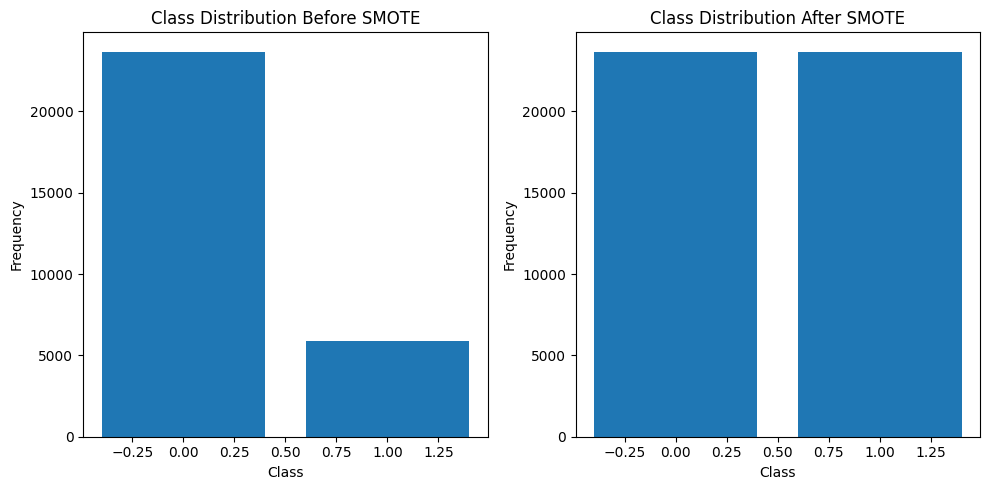

In [ ]:
#Melakukan pengecekan hasil SMOTE
from collections import Counter

# Check class distribution before SMOTE
print("Original class distribution in training data:")
print(Counter(y_train1))

# Check class distribution after SMOTE
print("\nClass distribution in training data after SMOTE:")
print(Counter(y_train_smote1))

# Optional: Visualize the class distribution if needed
import matplotlib.pyplot as plt

# Plot class distribution before SMOTE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(Counter(y_train1).keys(), Counter(y_train1).values())
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Plot class distribution after SMOTE
plt.subplot(1, 2, 2)
plt.bar(Counter(y_train_smote1).keys(), Counter(y_train_smote1).values())
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#Mekanisme 2. Undersampling
rawdata_train2 = rawdata_train1.copy()
rawdata_test2 = rawdata_test1.copy()
rawdata_validation2 = rawdata_validation1.copy()

x_train2 = rawdata_train2.drop(columns=['Heart_Disease'])
y_train2 = rawdata_train2['Heart_Disease']

x_test2 = rawdata_test2.drop(columns=['Heart_Disease'])
y_test2 = rawdata_test2['Heart_Disease']

x_validation2 = rawdata_validation2.drop(columns=['Heart_Disease'])
y_validation2 = rawdata_validation2['Heart_Disease']

In [ ]:
# Step 1: Apply undersampling to the training set
undersampler = RandomUnderSampler(random_state=42)

# Fit and resample only the training data
x_train_balanced2, y_train_balanced2 = undersampler.fit_resample(x_train2, y_train2)

# Check the new class distribution after undersampling
print("Class distribution after undersampling:", y_train_balanced2.value_counts())

# Step 2: Scale the undersampled data
scaler = StandardScaler()
x_train_scaled_balance2 = scaler.fit_transform(x_train_balanced2)
x_test_scaled2 = scaler.transform(x_test2)
x_validation_scaled2 = scaler.transform(x_validation1)

Class distribution after undersampling: Heart_Disease
0    5900
1    5900
Name: count, dtype: int64


## C.2 Data Preparation Dataset 2 : Dataset Fuzzy

In [ ]:
# Melakukan pendefinisian terhadap fitur untuk variabel input dan target atau variabel output
X = fuzzy_clean[['Age','Sex','BMI','Diabetes_diagnose','Glucose','Systolic_pressure','Diastolic_pressure','Smoking_History','LDL_cholesterol','OtherLifestyle_factors']]
y = fuzzy_clean['encoded']

# Melakukan splitting pada dataset fuzzy
X_ftrain, X_temp, y_ftrain, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_ftest, X_fval, y_ftest, y_fval = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

# **D. Modelling**

## D.3. Random Forest on Raw Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize RandomForest Classifier with adjusted parameters
classifier_rf = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,      # Number of trees in the forest
    max_depth=20,          # Limit on the depth of each tree
    min_samples_split=5,   # Minimum number of samples required to split an internal node
    min_samples_leaf=2,    # Minimum number of samples required to be at a leaf node
    bootstrap=True,        # Use bootstrap samples when building trees
    random_state=42,       # Random seed for reproducibility
    max_features='sqrt'    # Number of features to consider when looking for the best split
)

# Fit the model using cross-validation
cv_scores_roc = cross_val_score(classifier_rf, x_train_smote1, y_train_smote1, cv=5, scoring='roc_auc')
cv_scores = cross_val_score(classifier_rf, x_train_smote1, y_train_smote1, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores: ", cv_scores)
print("Mean Cross-Validation Accuracy: ", cv_scores.mean())
print("ROC Score on Train Set: ", cv_scores_roc.mean())

# Fit the model
classifier_rf.fit(x_train_smote1, y_train_smote1)

# Predict on test set
y_test_pred = classifier_rf.predict(x_test_scaled1)
y_test_prob = classifier_rf.predict_proba(x_test_scaled1)[:, 1]

# Predict on validation set
y_validation_pred = classifier_rf.predict(x_validation_scaled1)
y_validation_prob = classifier_rf.predict_proba(x_validation_scaled1)[:, 1]

# Evaluate the model
print("Accuracy on Test Set: ", '{0:.2%}'.format(accuracy_score(y_test1, y_test_pred)))
print("Classification Report on Test Set:\n", classification_report(y_test1, y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test1, y_test_pred))
print("ROC AUC Score on Test Set: ", '{0:.2%}'.format(roc_auc_score(y_test1, y_test_prob)))

print("Accuracy on Validation Set: ", '{0:.2%}'.format(accuracy_score(y_validation1, y_validation_pred)))
print("Classification Report on Validation Set:\n", classification_report(y_validation1, y_validation_pred))
print("Confusion Matrix on Validation Set:\n", confusion_matrix(y_validation1, y_validation_pred))
print("ROC AUC Score on Validation Set: ", '{0:.2%}'.format(roc_auc_score(y_validation1, y_validation_prob)))

Cross-Validation Accuracy Scores:  [0.70295671 0.75659979 0.77550158 0.78287042 0.78287042]
Mean Cross-Validation Accuracy:  0.760159783333443
ROC Score on Train Set:  0.8449041155482492
Accuracy on Test Set:  67.04%
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.85      0.71      0.78      6798
           1       0.30      0.51      0.38      1694

    accuracy                           0.67      8492
   macro avg       0.58      0.61      0.58      8492
weighted avg       0.74      0.67      0.70      8492

Confusion Matrix on Test Set:
 [[4836 1962]
 [ 837  857]]
ROC AUC Score on Test Set:  66.36%
Accuracy on Validation Set:  66.05%
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.85      0.70      0.77      3349
           1       0.29      0.50      0.37       834

    accuracy                           0.66      4183
   macro avg       0.57      0.

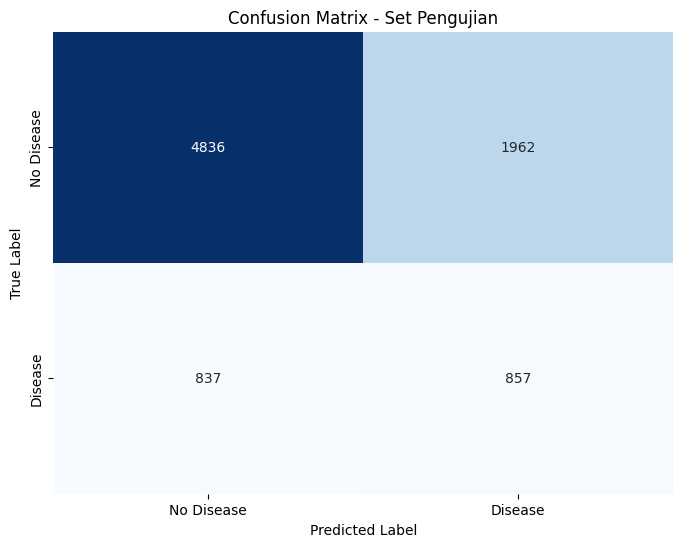

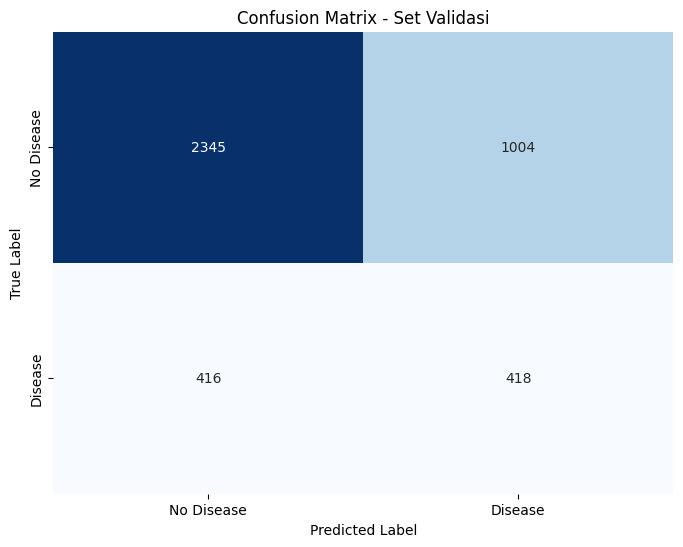

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test1, y_test_pred)

# Create a heatmap to visualize the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'],  # Modify labels as needed
            yticklabels=['No Disease', 'Disease'])

# Add labels and title for the test set
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Set Pengujian')

# Show the plot for the test set
plt.show()

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_validation1, y_validation_pred)

# Create a heatmap to visualize the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'],  # Modify labels as needed
            yticklabels=['No Disease', 'Disease'])

# Add labels and title for the validation set
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Set Validasi')

# Show the plot for the validation set
plt.show()

<Figure size 800x600 with 0 Axes>

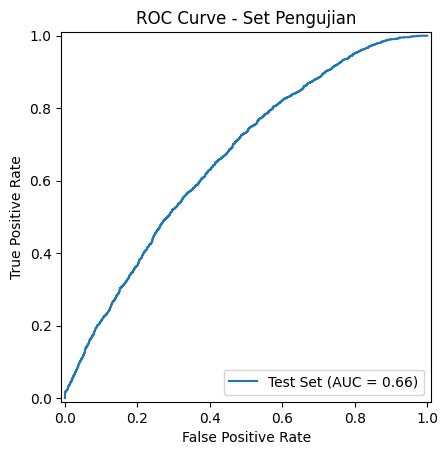

<Figure size 800x600 with 0 Axes>

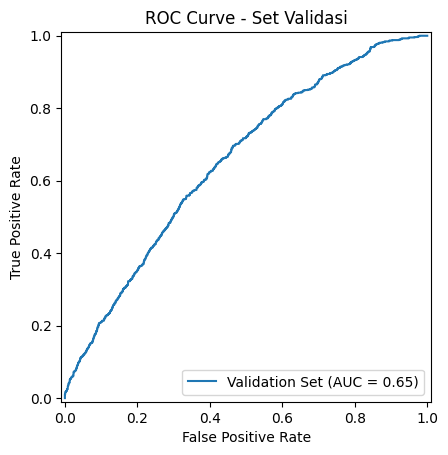

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

# Calculate ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_test1, y_test_prob)
roc_auc_test = roc_auc_score(y_test1, y_test_prob)

# Display the ROC curve for the test set
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test, estimator_name='Test Set').plot()
plt.title('ROC Curve - Set Pengujian')
plt.show()

# Calculate ROC curve and AUC for the validation set
fpr_val, tpr_val, _ = roc_curve(y_validation1, y_validation_prob)
roc_auc_val = roc_auc_score(y_validation1, y_validation_prob)

# Display the ROC curve for the validation set
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_val, tpr=tpr_val, roc_auc=roc_auc_val, estimator_name='Validation Set').plot()
plt.title('ROC Curve - Set Validasi')
plt.show()

In [ ]:
data_importances = data_final5.copy()
data_importances = data_importances.drop(columns = ['Heart_Disease'])

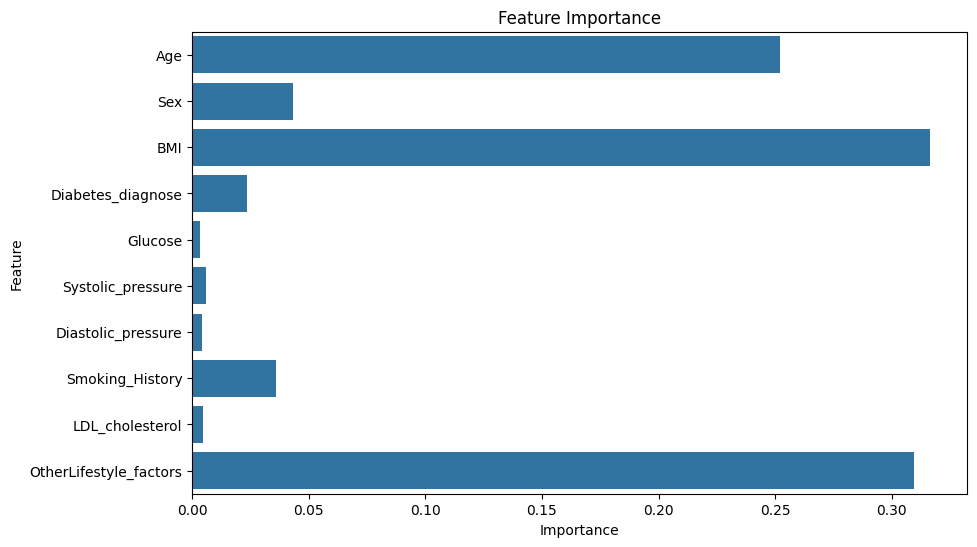

In [ ]:
importances = classifier_rf.feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=data_importances.columns)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## D.2 Random Forest Raw Data + Optimization

1. Hyperparameter Search



In [ ]:
#Hyperparameter tuning with GridSearch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

classifier_rf_optimized = RandomForestClassifier(
    bootstrap=True,
    random_state=42,
    class_weight='balanced'
)

param_grid = {
    'n_estimators' : [100,200,300],
    'max_depth' : [10,20,30],
    'min_samples_split' :[2,5,10,30],
    'min_samples_leaf' :[1,2,4],
    'max_features' : ['sqrt','log2'] # max_features 8 itu based on hipotesis dan insight yang ditemukan selama melakukan EDA
}

grid_search_rf = GridSearchCV(classifier_rf_optimized, param_grid = param_grid, cv=5,
                              scoring='roc_auc', error_score='raise')
grid_search_rf.fit(x_train_smote1, y_train_smote1)
print("Best parameters:", grid_search_rf.best_params_)
print("Best score:", grid_search_rf.best_score_)
best_rf_model = grid_search_rf.best_estimator_

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score: 0.866697798452793


2. Model with optimization

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# Initialize RandomForest Classifier with adjusted parameters
classifier_rf_optimized = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=300,      # Number of trees in the forest
    max_depth=30,          # Limit on the depth of each tree
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node
    bootstrap=True,        # Use bootstrap samples when building trees
    random_state=42,       # Random seed for reproducibility
    max_features='sqrt'    # Number of features to consider when looking for the best split
)


# Model Execution
classifier_rf_optimized.fit(x_train_smote1, y_train_smote1)

# Evaluate Model on Train Set
cv_scores_opt = cross_val_score(classifier_rf_optimized, x_train_smote1, y_train_smote1, cv=5, scoring='accuracy')
cv_score_roc_opt = cross_val_score(classifier_rf_optimized, x_train_smote1, y_train_smote1, cv=5, scoring ='roc_auc')
print("Cross-Validation Accuracy Scores: ", cv_scores_opt)
print("Mean Cross-Validation Accuracy: ", cv_scores_opt.mean())
print("ROC AUC Score on Train Set: ", cv_score_roc_opt.mean())

# Predict on test set
y_test_pred_opt = classifier_rf_optimized.predict(x_test_scaled1)
y_test_prob_opt = classifier_rf_optimized.predict_proba(x_test_scaled1)[:, 1]

# Predict on validation set
y_validation_pred_opt = classifier_rf_optimized.predict(x_validation_scaled1)
y_validation_prob_opt = classifier_rf_optimized.predict_proba(x_validation_scaled1)[:, 1]

# Evaluate the model
print("Accuracy on Test Set: ", '{0:.2%}'.format(accuracy_score(y_test1, y_test_pred_opt)))
print("Classification Report on Test Set:\n", classification_report(y_test1, y_test_pred_opt))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test1, y_test_pred_opt))
print("ROC AUC Score on Test Set: ", '{0:.2%}'.format(roc_auc_score(y_test1, y_test_prob_opt)))

print("Accuracy on Validation Set: ", '{0:.2%}'.format(accuracy_score(y_validation1, y_validation_pred_opt)))
print("Classification Report on Validation Set:\n", classification_report(y_validation1, y_validation_pred_opt))
print("Confusion Matrix on Validation Set:\n", confusion_matrix(y_validation1, y_validation_pred_opt))
print("ROC AUC Score on Validation Set: ", '{0:.2%}'.format(roc_auc_score(y_validation1, y_validation_prob_opt)))

Cross-Validation Accuracy Scores:  [0.7345301  0.78711721 0.81003168 0.80198543 0.81096209]
Mean Cross-Validation Accuracy:  0.7889252998418783
ROC AUC Score on Train Set:  0.8712585031254665
Accuracy on Test Set:  68.55%
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.83      0.77      0.80      6798
           1       0.28      0.36      0.31      1694

    accuracy                           0.69      8492
   macro avg       0.55      0.56      0.55      8492
weighted avg       0.72      0.69      0.70      8492

Confusion Matrix on Test Set:
 [[5212 1586]
 [1085  609]]
ROC AUC Score on Test Set:  63.37%
Accuracy on Validation Set:  68.32%
Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      3349
           1       0.28      0.36      0.31       834

    accuracy                           0.68      4183
   macro avg       0.55   

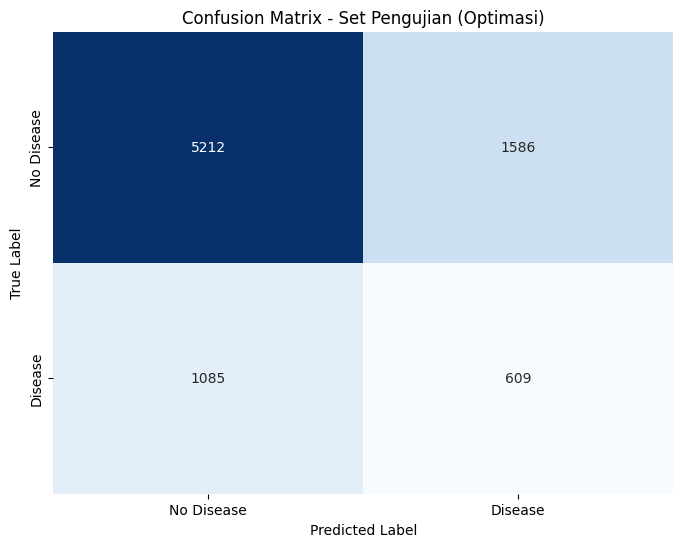

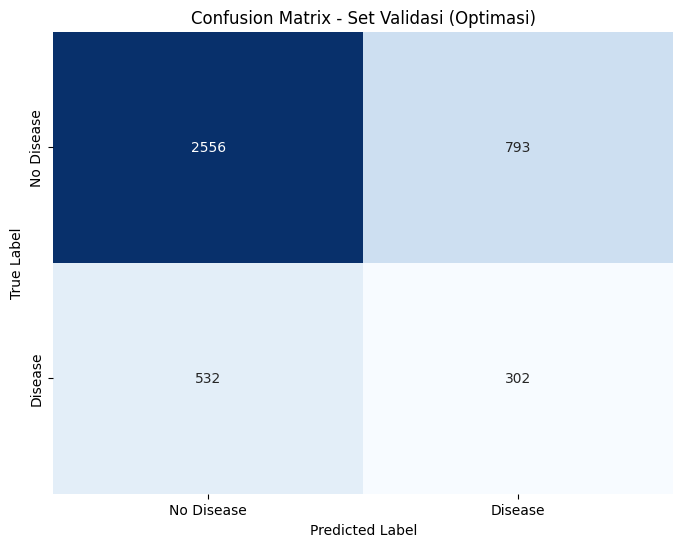

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test1, y_test_pred_opt)

# Create a heatmap to visualize the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'],  # Modify labels as needed
            yticklabels=['No Disease', 'Disease'])

# Add labels and title for the test set
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Set Pengujian (Optimasi)')

# Show the plot for the test set
plt.show()

# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_validation1, y_validation_pred_opt)

# Create a heatmap to visualize the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Disease', 'Disease'],  # Modify labels as needed
            yticklabels=['No Disease', 'Disease'])

# Add labels and title for the validation set
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Set Validasi (Optimasi)')

# Show the plot for the validation set
plt.show()

<Figure size 800x600 with 0 Axes>

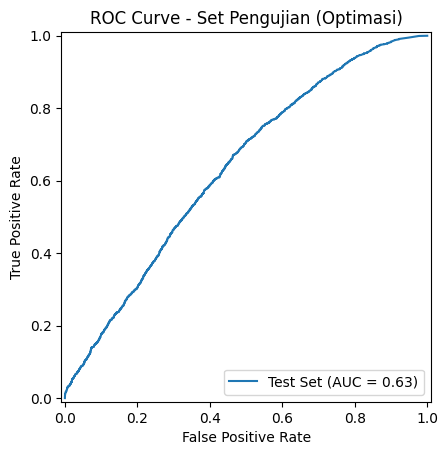

<Figure size 800x600 with 0 Axes>

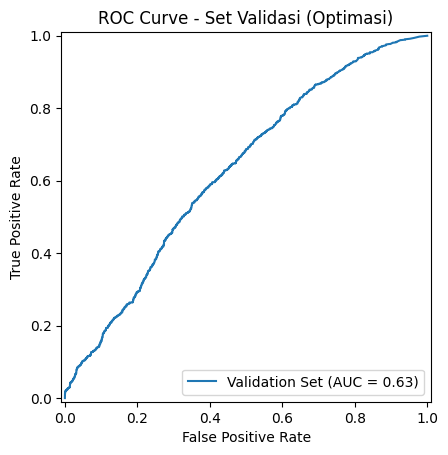

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

# Calculate ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(y_test1, y_test_prob_opt)
roc_auc_test = roc_auc_score(y_test1, y_test_prob_opt)

# Display the ROC curve for the test set
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test, estimator_name='Test Set').plot()
plt.title('ROC Curve - Set Pengujian (Optimasi)')
plt.show()

# Calculate ROC curve and AUC for the validation set
fpr_val, tpr_val, _ = roc_curve(y_validation1, y_validation_prob_opt)
roc_auc_val = roc_auc_score(y_validation1, y_validation_prob_opt)

# Display the ROC curve for the validation set
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_val, tpr=tpr_val, roc_auc=roc_auc_val, estimator_name='Validation Set').plot()
plt.title('ROC Curve - Set Validasi (Optimasi)')
plt.show()
from sklearn.metrics import RocCurveDisplay
plt.figure(figsize = (10,8))

In [ ]:
importances_optimized = classifier_rf_optimized.feature_importances_

In [ ]:
print(importances_optimized)

[0.15330989 0.02283394 0.39681387 0.01009154 0.00266135 0.00206101
 0.00269167 0.01985041 0.00302918 0.38665713]


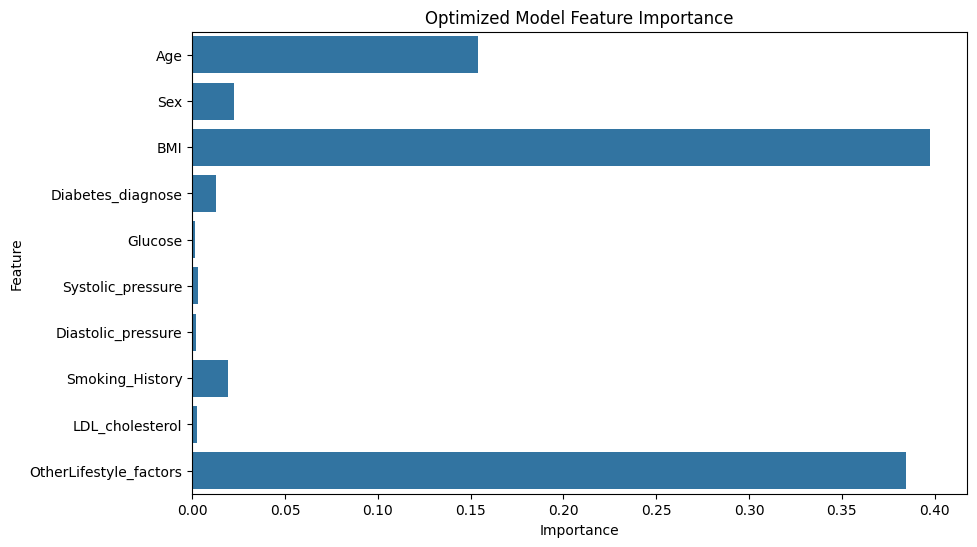

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_optimized, y=data_importances.columns)
plt.title('Optimized Model Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## D.3 Random Forest Fuzzy Data

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_score
# Melakukan definisi terhadap parameter model yang akan dibangun, berdasarkan hyperparameter tuning yang telah dilakukan
fuzzy_rf_classifier = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=10,
    min_samples_leaf=1,
    bootstrap=True,
    random_state=42,
    max_features='sqrt'
    )

# Eksekusi pemodelan pada dataset pelatihan
fuzzy_rf_classifier.fit(X_ftrain, y_ftrain)

# Melakukan evaluasi model pada dataset pelatihan dengan teknik cross validation
fcv_scores_roc = cross_val_score(fuzzy_rf_classifier, X_ftrain, y_ftrain, cv=5, scoring='roc_auc_ovo')
fcv_scores = cross_val_score(fuzzy_rf_classifier, X_ftrain, y_ftrain, cv=5, scoring='accuracy')
print("Skor Akurasi Cross-Validation pada Dataset Pelatihan Fuzzy: ", fcv_scores)
print("Skor Akurasi Mean Cross-Validation pada Dataset Pelatihan Fuzzy: ", fcv_scores.mean())
print("Skor ROC AUC Score pada Dataset Pelatihan Fuzzy: ", fcv_scores_roc.mean())


# Melakukan prediksi terhadap dataset pengujian
y_test_pred_fuzz = fuzzy_rf_classifier.predict(X_ftest)
y_test_prob_fuzz = fuzzy_rf_classifier.predict_proba(X_ftest)

# Melakukan prediksi terhadap dataset validasi
y_validation_pred_fuzz = fuzzy_rf_classifier.predict(X_fval)
y_validation_prob_fuzz = fuzzy_rf_classifier.predict_proba(X_fval)

# Evaluasi pada Dataset Pengujian dan Validasi
print("Skor Accuracy pada Dataset Pengujian Fuzzy: ", '{0:.2%}'.format(accuracy_score(y_ftest, y_test_pred_fuzz)))
print("Hasil Classification Report pada Dataset Pengujian Fuzzy:\n", classification_report(y_ftest, y_test_pred_fuzz))
print("Confussion Matrix pada Dataset Pengujian Fuzzy: \n", confusion_matrix(y_ftest, y_test_pred_fuzz))
print("Skor ROC AUC Score pada Dataset Pengujian Fuzzy: ", '{0:.2%}'.format(roc_auc_score(y_ftest, y_test_prob_fuzz, multi_class ='ovo'))) # Melakukan komparasi pada tiap kelas

print("Skor Accuracy pada Dataset Validasi Fuzzy: ", '{0:.2%}'.format(accuracy_score(y_fval, y_validation_pred_fuzz)))
print("Hasil Classification Report pada Dataset Validasi Fuzzy:\n", classification_report(y_fval, y_validation_pred_fuzz))
print("Confussion Matrix pada Dataset Validasi Fuzzy", confusion_matrix(y_fval, y_validation_pred_fuzz))
print("Skor ROC AUC Score pada Dataset Validasi Fuzzy: ", '{0:.2%}'.format(roc_auc_score(y_fval, y_validation_prob_fuzz, multi_class ='ovo'))) # Melakukan komparasi pada tiap kelas

Skor Akurasi Cross-Validation pada Dataset Pelatihan Fuzzy:  [0.99087067 0.99120879 0.99171598 0.99171598 0.99086912]
Skor Akurasi Mean Cross-Validation pada Dataset Pelatihan Fuzzy:  0.9912761071555067
Skor ROC AUC Score pada Dataset Pelatihan Fuzzy:  0.9879000301355954
Skor Accuracy pada Dataset Pengujian Fuzzy:  99.34%
Hasil Classification Report pada Dataset Pengujian Fuzzy:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.97      0.88      0.92       128
           2       0.99      1.00      1.00      3666
           3       0.99      0.99      0.99       291
           4       1.00      0.98      0.99       122

    accuracy                           0.99      4225
   macro avg       0.99      0.96      0.97      4225
weighted avg       0.99      0.99      0.99      4225

Confussion Matrix pada Dataset Pengujian Fuzzy: 
 [[  17    1    0    0    0]
 [   0  113   15    0    0]
 [   0    3 3661    2 

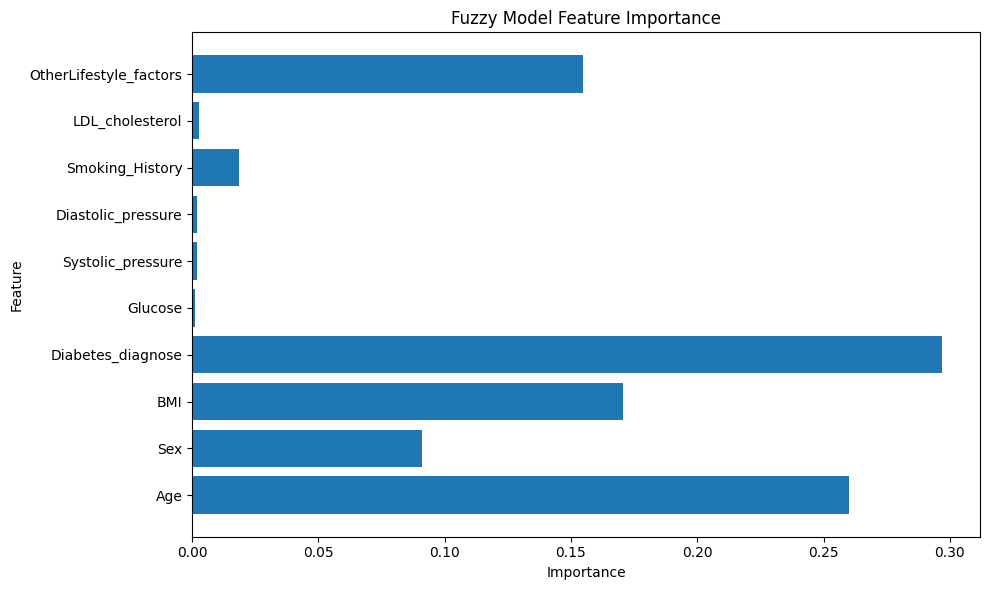

In [ ]:
f_importances = fuzzy_rf_classifier.feature_importances_
feature_names = X_ftrain.columns
# Visualisasi plot
plt.figure(figsize=(10, 6))
plt.title("Fuzzy Model Feature Importance")
plt.barh(range(len(f_importances)), f_importances, align="center")
plt.yticks(range(len(f_importances)), feature_names)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

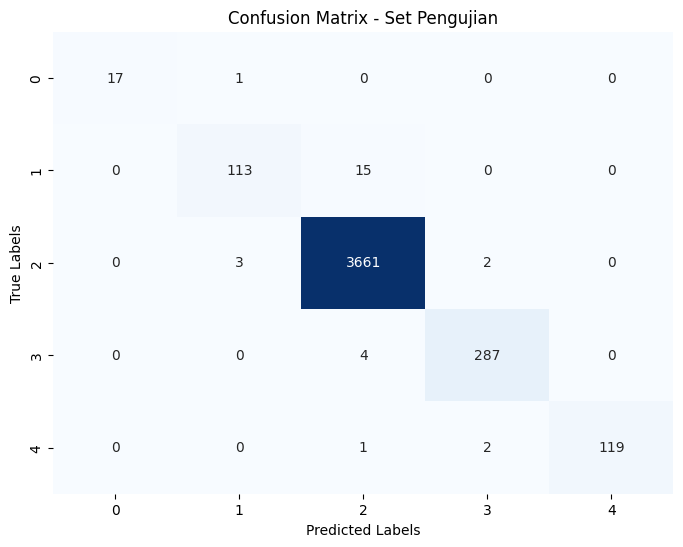

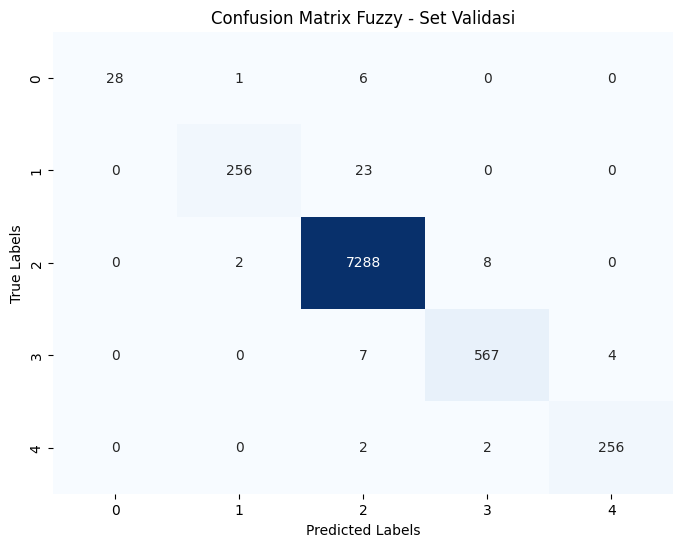

In [ ]:
#import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Kalkulasi confusion matrix untuk set pengujian
cm_test = confusion_matrix(y_ftest, y_test_pred_fuzz)

# Visualisasi Confusion Matrix Fuzzy untuk dataset pengujian
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix - Set Pengujian')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Kalkulasi confusion matrix untuk set validasi
cm_val = confusion_matrix(y_fval, y_validation_pred_fuzz)

# Visualisasi Confusion Matrix Fuzzy untuk dataset validasi
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix Fuzzy - Set Validasi')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

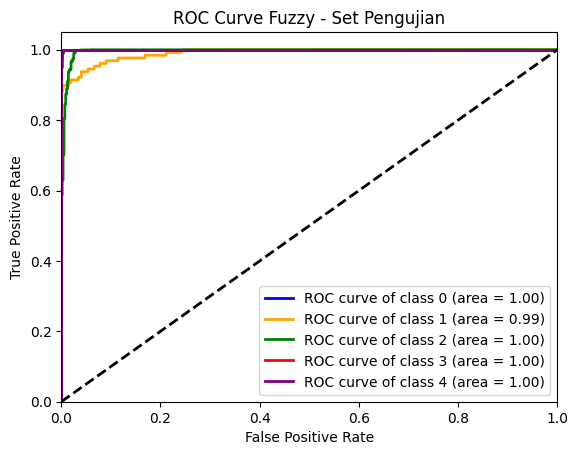

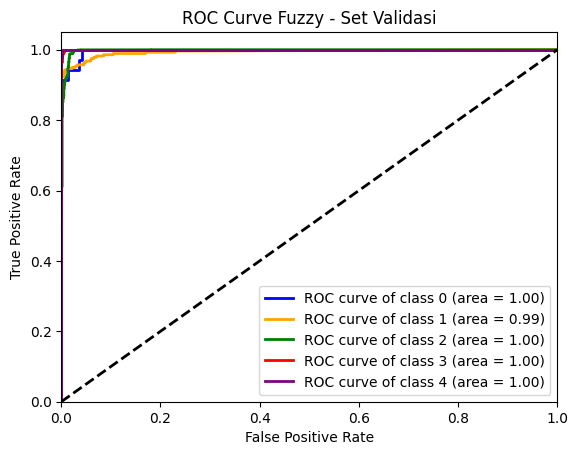

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
y_fval_bin = label_binarize(y_fval, classes=[0, 1, 2, 3, 4])
y_ftest_bin = label_binarize(y_ftest, classes=[0, 1, 2, 3, 4])

n_classes = y_fval_bin.shape[1]

# ROC Curve untuk dataset pengujian
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()

for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_ftest_bin[:, i], y_test_prob_fuzz[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Visualisasi plot ROC Curve untuk dataset pengujian
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc_test[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Fuzzy - Set Pengujian')
plt.legend(loc="lower right")
plt.show()

# ROC Curve untuk dataset validasi
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_fval_bin[:, i], y_validation_prob_fuzz[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Visualisasi plot ROC Curve untuk dataset validasi
plt.figure()
colors = ['blue', 'orange', 'green', 'red', 'purple']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Fuzzy - Set Validasi')
plt.legend(loc="lower right")
plt.show()